# EXPLORED EDA - NLP

## IMPORTS

In [33]:
# ---------------------------------------------------------
# GENERAL IMPORTS
# ---------------------------------------------------------
# CORE PYTHON & DATA MANIPULATION LIBRARIES
import numpy as np                # Numerical computations, arrays, math operations
import pandas as pd               # Data handling, DataFrames, time-series structures
import warnings                   # Warning control and suppression
import math                       # Math utilities (sqrt, log, floor, ceil, etc.)
import random                     # Generate random values
# VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt   # Main plotting library
import seaborn as sns             # Statistical and enhanced visualization tools
from wordcloud import WordCloud   # Wordcloud plotting
# DATA SPLIT UTILITIES
from sklearn.model_selection import train_test_split   # Split dataset into train / test subsets
# MODEL SELECTION
from sklearn.model_selection import GridSearchCV       # Hyperparameter optimization via grid search
from sklearn.tree import plot_tree                     # Visualization of decision tree structures
from pickle import dump                                # Save trained models to disk (serialization)

# ---------------------------------------------------------
# CLASSIFICATION ALGORITHMS
# ---------------------------------------------------------
# METRICS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score   # Core classification metrics
# PREDICTION MODELS
from sklearn.linear_model import LogisticRegression     # Logistic regression classifier
from sklearn.tree import DecisionTreeClassifier         # Decision tree classifier
from sklearn.naive_bayes import GaussianNB              # Gaussian Naive Bayes for continuous inputs
from sklearn.naive_bayes import MultinomialNB           # Multinomial Naive Bayes (common for NLP)
from sklearn.naive_bayes import BernoulliNB             # Bernoulli Naive Bayes (binary features)
# BAGGING ENSEMBLE
from sklearn.ensemble import RandomForestClassifier     # Ensemble of decision trees (bagging)
# BOOSTING ENSEMBLE
from sklearn.ensemble import AdaBoostClassifier         # AdaBoost boosting algorithm
from sklearn.ensemble import GradientBoostingClassifier # Gradient boosting classifier
from xgboost import XGBClassifier                       # Extreme Gradient Boosting (high-performance)
from lightgbm import LGBMClassifier                     # LightGBM (optimized gradient boosting)

# ---------------------------------------------------------
# REGRESSION ALGORITHMS
# ---------------------------------------------------------
# METRICS
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score   # Regression performance metrics
# PREDICTION MODELS
from sklearn.linear_model import LinearRegression       # Linear regression model
from sklearn.linear_model import Lasso                  # L1 regularized regression
from sklearn.linear_model import Ridge                  # L2 regularized regression
from sklearn.tree import DecisionTreeRegressor          # Regression decision tree
# BAGGING ENSEMBLE
from sklearn.ensemble import RandomForestRegressor      # Ensemble of regression trees (bagging)
# BOOSTING ENSEMBLE
from sklearn.ensemble import AdaBoostRegressor          # Boosting algorithm for regression
from sklearn.ensemble import GradientBoostingRegressor  # Gradient boosting regressor
from xgboost import XGBRegressor                        # XGBoost regressor
from lightgbm import LGBMRegressor                      # LightGBM regressor

# ---------------------------------------------------------
# NLP DATASETS - EDA
# ---------------------------------------------------------
import regex as re                          # Advanced regular expressions for robust text cleaning
import nltk                                 # NLP toolkit required for lemmatization and POS tagging
from nltk.stem import WordNetLemmatizer     # Lemmatizer based on WordNet lexical database
from nltk.corpus import stopwords           # Stopword lists for multiple languages
from nltk.corpus import wordnet             # WordNet POS tags for accurate lemmatization
from PIL import Image                       # Load and manipulate image files (used for mask shapes in WordCloud)
try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet", quiet=True)
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords", quiet=True)

try:
    nltk.data.find("taggers/averaged_perceptron_tagger")
except LookupError:
    nltk.download("averaged_perceptron_tagger", quiet=True)


# STEP 13) VECTORIZATION
from sklearn.feature_extraction.text import CountVectorizer     # Convert text into token frequency counts
from sklearn.feature_extraction.text import TfidfVectorizer     # Convert text into TF-IDF weighted features
from sklearn.decomposition import PCA                           # Dimensionality reduction (e.g., for visualization)
from sklearn.metrics import silhouette_score                    # Clustering quality metric (optional for NLP clustering)

# ---------------------------------------------------------
# TIME-SERIES DATASETS - EDA
# ---------------------------------------------------------
# STEP 3) DECOMPOSING
from statsmodels.tsa.seasonal import seasonal_decompose         # Decompose time-series into trend, seasonal, and residual components
# STEP 4) STATIONARITY ANALYSIS
from statsmodels.tsa.stattools import adfuller                  # Dickey-Fuller test for stationarity evaluation
# STEP 5) VARIABILITY ANALYSIS
from statsmodels.stats.diagnostic import acorr_ljungbox         # Ljung-Box test for checking autocorrelation in residuals
# STEP 6) AUTOCORRELATION ANALYSIS
from statsmodels.tsa.stattools import acf                       # Compute autocorrelation values  
from statsmodels.tsa.stattools import pacf                      # Compute partial autocorrelation values
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # Plot ACF & PACF with confidence bands
# STEP 16) PREDICTION MODELS
from statsmodels.tsa.arima.model import ARIMA                   # ARIMA(p,d,q) model for forecasting
from pmdarima import auto_arima                                 # Automatic ARIMA/SARIMA parameter selection
from statsmodels.tools.sm_exceptions import ConvergenceWarning  # Warning raised when ARIMA optimizer fails
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # Suppress convergence warnings globally (keeps logs clean)

# ---------------------------------------------------------
# TABULAR DATASETS - EDA
# ---------------------------------------------------------
# STEP 10) REMOVE NOISY ATTRIBUTES
from scipy.stats import chi2_contingency                # Chi-square test for categorical dependencies
# STEP 12) SCALLING
from sklearn.preprocessing import StandardScaler        # Standardization (mean=0, std=1)
from sklearn.preprocessing import MinMaxScaler          # Min-max scaling to [0,1]
# STEP 13) ENCODING
from sklearn.preprocessing import LabelEncoder          # Encode categories into integer labels
from sklearn.preprocessing import OneHotEncoder         # Encode categories into binary vectors
# STEP 14) FEATURE SELECTION
from sklearn.feature_selection import SelectKBest, f_classif   # Univariate feature selection for classification

## HELPER FUNCTIONS

In [34]:
# ---------------------------------------------------------
# COMMON
# ---------------------------------------------------------
# Log printer
def log(message: str, level: int = 1, type: str = "INFO", custom_icon: str = None, bold: bool = False):
    # Default icons according to message type
    icons = {
        "INFO": "ℹ️",
        "FOUND": "🔍",
        "SUCCESS": "✅",
        "ERROR": "❌",
        "WARNING": "⚠️",
    }
    # Use custom icon if provided
    if custom_icon:
        icon = custom_icon
    else:
        icon = icons.get(type.upper(), "ℹ️")
    # Bold wrapper (ANSI)
    if bold:
        message = f"\033[1m{message}\033[0m"
    # First level → bullet
    if level == 1:
        prefix = "•"
    # Second level → indent + hyphen
    elif level == 2:
        prefix = "   -"
    # Level 3 → deeper indent + middle dot
    elif level == 3:
        prefix = "      ·"
    # Fallback
    else:
        prefix = "-"
    # Final print
    print(f"{prefix} {icon} {message}")

# -------------------------------
# NLP - EDA
# -------------------------------
# Adaptive text preprocessing: for natural text, URLs, and mixed content
def preprocess_text(text,
                    mode="auto",                # "auto", "text", "url"
                    lowercase_text=True,
                    remove_urls=True,           # Only applies in text mode
                    remove_emails=True,
                    remove_html_tags=True,
                    remove_non_letters=True,    # Only applies in text mode
                    remove_single_char_tokens=True,
                    reduce_whitespace=True,
                    tokenize_output=True):
    # Convert to string safely
    if text is None:
        return {"output": [], "mode_used": "none"}
    text = str(text)
    # Automatic URL detection
    def looks_like_url(s):
        if s.startswith("http://") or s.startswith("https://"):
            return True
        if re.search(r"\.[a-z]{2,4}(/|$)", s):   # domain-like pattern
            return True
        return False
    # Decide mode
    if mode == "auto":
        is_url = looks_like_url(text)
    elif mode == "url":
        is_url = True
    else:
        is_url = False
    # URL MODE
    if is_url:
        mode_used = "url"
        if lowercase_text:
            text = text.lower()
        # Split URL into meaningful tokens
        text = re.sub(r'[:/\.\?\=\&\-\_#]+', ' ', text)
        if remove_single_char_tokens:
            text = re.sub(r'\b[a-z]\b', ' ', text)
        if reduce_whitespace:
            text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        if tokenize_output:
            tokens = text.split()
            clean_tokens = []
            for tok in tokens:
                if tok:
                    clean_tokens.append(tok)
            return {"output": clean_tokens, "mode_used": mode_used}
        return {"output": text, "mode_used": mode_used}
    # TEXT MODE
    mode_used = "text"
    if lowercase_text:
        text = text.lower()
    if remove_urls:
        text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    if remove_emails:
        text = re.sub(r'\S+@\S+\.\S+', ' ', text)
    if remove_html_tags:
        text = re.sub(r'<.*?>', ' ', text)
    if remove_non_letters:
        text = re.sub(r'[^a-z\s]', ' ', text)
    if remove_single_char_tokens:
        text = re.sub(r'\b[a-z]\b', ' ', text)
    if reduce_whitespace:
        text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    if tokenize_output:
        tokens = text.split()
        return {"output": tokens, "mode_used": mode_used}
    return {"output": text, "mode_used": mode_used}

# Convert NLTK POS tags to WordNet POS tags
def nltk_pos_to_wordnet_pos(nltk_pos):
    if nltk_pos.startswith("J"):
        return wordnet.ADJ
    if nltk_pos.startswith("V"):
        return wordnet.VERB
    if nltk_pos.startswith("N"):
        return wordnet.NOUN
    if nltk_pos.startswith("R"):
        return wordnet.ADV
    return None

# Lemmatize tokens
def lemmatize_tokens(tokens,
                     apply_stopword_removal=True,
                     stopword_language="english",
                     case_sensitive_stopwords=False,
                     apply_pos_tagging=False,
                     exclude_digits=True,
                     min_word_length=3):
    # Return empty list if input is invalid (none or not a list)
    if tokens is None or not isinstance(tokens, list):
        return []
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Load stopwords
    if apply_stopword_removal:
        try:
            stop_words = stopwords.words(stopword_language)
        except:
            stop_words = stopwords.words("english")
        if not case_sensitive_stopwords:
            normalized_stopwords = []
            for w in stop_words:
                word_lower = w.lower()
                normalized_stopwords.append(word_lower)
            stop_words = normalized_stopwords
    else:
        stop_words = []
    # If POS tagging enabled, get tags
    if apply_pos_tagging:
        pos_tagged = nltk.pos_tag(tokens)
    else:
        pos_tagged = []
        for tok in tokens:
            pos_tagged.append((tok, None)) 
    # Process each token
    clean_tokens = []
    for token, pos_tag in pos_tagged:
        if token is None:
            continue
        tok = token.lower()
        # Remove stopwords
        if apply_stopword_removal and tok in stop_words:
            continue
        # Remove tokens made only of digits
        if exclude_digits and tok.isdigit():
            continue
        # Apply lemmatization
        if pos_tag is not None:
            wn_pos = nltk_pos_to_wordnet_pos(pos_tag)
            if wn_pos is not None:
                tok = lemmatizer.lemmatize(tok, pos=wn_pos)
            else:
                tok = lemmatizer.lemmatize(tok)
        else:
            tok = lemmatizer.lemmatize(tok)
        # Remove tokens that are too short after processing
        if len(tok) < min_word_length:
            continue
        clean_tokens.append(tok)
    return clean_tokens

# ---------------------------------------------------------
# TABULAR DATASETS - EDA
# ---------------------------------------------------------
#  Computes correlation between CATEGORIC attributes by using Cramér's V
def cramers_v(x, y): 
    # Step 1: confusion matrix
    confusion_matrix = pd.crosstab(x, y)
    # Step 2: chi-square statistic
    chi2 = chi2_contingency(confusion_matrix)[0]
    # Step 3: phi-squared
    total_samples = confusion_matrix.sum().sum()
    phi2 = chi2 / total_samples
    # Shape of confusion matrix
    r, k = confusion_matrix.shape
    num_rows = confusion_matrix.shape[0]
    num_cols = confusion_matrix.shape[1]
    # Step 4: bias correction (recommended formula)
    correction = ((num_cols - 1) * (num_rows - 1)) / (total_samples - 1)
    phi2_corrected = max(0, phi2 - correction)
    # Corrected dimensions
    rows_corrected = num_rows - ((num_rows - 1) ** 2) / (total_samples - 1)
    cols_corrected = num_cols - ((num_cols - 1) ** 2) / (total_samples - 1)
    # Step 5: compute Cramér's V
    denominator = min(rows_corrected - 1, cols_corrected - 1)
    if denominator <= 0:
        return 0  # avoid division by zero for degenerate tables
    cramers_v_value = np.sqrt(phi2_corrected / denominator)
    return cramers_v_value
    
# ---------------------------------------------------------
# TIME-SERIES DATASETS - EDA
# ---------------------------------------------------------
# Determines granularity given seconds
def determine_granularity(seconds: float):
    if seconds < 1:
        granularity = "sub-second"
    elif seconds >= 1 and seconds < 60:
        granularity = "second"
    elif seconds >= 60 and seconds < 3600:
        granularity = "minute"
    elif seconds >= 3600 and seconds < 86400:
        granularity = "hour"
    elif seconds == 86400:
        granularity = "day"
    elif seconds > 86400 and seconds <= 86400 * 7:
        granularity = "multi-day"
    elif seconds == 86400 * 7:
        granularity = "week"
    elif seconds > 86400 * 7 and seconds < 86400 * 28:
        granularity = "weekly-to-monthly"
    elif seconds >= 86400 * 28 and seconds <= 86400 * 31:
        granularity = "month"
    elif seconds > 86400 * 31 and seconds <= 86400 * 92:
        granularity = "quarter"
    else:
        granularity = "year-or-more"
    return granularity

# Detects whether the seasonal decomposition model should be
# 'additive' (constant amplitude) or 
# 'multiplicative'(amplitude grows with the trend)
def infer_seasonal_component_type(series: pd.Series, threshold: float) -> str:
    # Compute amplitude and mean
    amplitude = series.max() - series.min()
    mean_val = series.mean()
    # Edge case: zero-mean → multiplicative impossible
    if mean_val == 0:
        return "additive"
    # Threshold for deciding multiplicative
    if amplitude / abs(mean_val) > threshold:
        return "multiplicative"
    else:
        return "additive"

#  Detects seasonality period automatically using the first significant ACF peak
def infer_period_from_acf(series: pd.Series, max_lag_ratio: float = 0.1):
    n = len(series)
    max_lag = max(5, int(n * max_lag_ratio))
    # Compute autocorrelation using FFT
    autocorr = acf(series, nlags=max_lag, fft=True, missing="drop")
    # Ignore lag 0
    autocorr[0] = 0
    # Find the highest correlation peak
    peak_lag = np.argmax(autocorr)
    # If the peak is too low → no seasonality
    if autocorr[peak_lag] < 0.3:
        return None
    return peak_lag

#  Detects seasonality period automatically using Granularity (fallback when ACF fails or data is too noisy)
def infer_period_from_granularity(granularity: str):
    if granularity == "sub-second":
        return None
    if granularity == "second":
        return 60
    if granularity == "minute":
        return 60
    if granularity == "hour":
        return 24
    if granularity == "day":
        return 7  # Most common weekly cycle IF the series shows any seasonality
    if granularity == "multi-day":
        return 7
    if granularity == "week":
        return 52
    if granularity == "weekly-to-monthly":
        return 12
    if granularity == "month":
        return 12
    if granularity == "quarter":
        return 4
    return None # Yearly or undefined → no decomposition

# 6) Evaluates how strong the seasonality is using:
# 1) Variance ratio: Var(seasonal) / Var(original)
# 2) ACF at the seasonal period
def assess_seasonality_strength(original: pd.Series, seasonal: pd.Series, period: int, acf_threshold: float, var_ratio: float):
    # Align indices and remove NaN values from the seasonal component
    valid_mask = seasonal.notna()
    original_valid = original[valid_mask]
    seasonal_valid = seasonal[valid_mask]
    # If there are not enough valid points → cannot assess
    if len(original_valid) < max(10, period * 2):
        metrics = {
            "seasonal_var_ratio": np.nan,
            "acf_at_period": np.nan
        }
        return False, metrics
    # 1) Variance ratio
    total_var = np.var(original_valid)
    seasonal_var = np.var(seasonal_valid)
    if total_var == 0:
        seasonal_var_ratio = 0.0
    else:
        seasonal_var_ratio = seasonal_var / total_var
    # 2) ACF at seasonal period
    acf_values = acf(
        original_valid,
        nlags = period,
        fft = True,
        missing = "drop"
    )
    acf_at_period = acf_values[period]
    # 3) Decision rule
    strong_seasonality = ((seasonal_var_ratio >= var_ratio) and (acf_at_period >= acf_threshold))
    # 4) Metrics
    metrics = {
        "seasonal_var_ratio": seasonal_var_ratio,
        "acf_at_period": acf_at_period
    }
    return strong_seasonality, metrics

# Performs Dickey-Fuller test to determine if a series is stacionary or not
def test_stationarity(series):
    dftest = adfuller(series, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# Recursively differences the time-series until Dickey-Fuller test accepts stationarity (p < alpha)
def make_stationary_recursive(series, alpha: float = 0.05, max_diff: int = 5):
    current_series = series.copy()
    diff_count = 0
    while diff_count <= max_diff:
        test_results = test_stationarity(current_series)
        if test_results["p-value"] < alpha:
            return current_series, diff_count, test_results
        current_series = current_series.diff().dropna()
        diff_count += 1
    # If exceeded max_diff → return last attempt
    return current_series, diff_count, test_results

# Function to get recommended lag based on granularity
def get_recommended_lag(granularity):
    if granularity == "sub-second" or granularity == "second":
        return 600   # Captures 10 minutes of autocorrelation
    if granularity == "minute":
        return 300   # Captures 5 hours
    if granularity == "hour":
        return 200   # Captures up to weekly cycles (168h)
    if granularity == "day":
        return 60    # Enough for weekly + monthly seasonality
    if granularity == "multi-day":
        return 60
    if granularity == "week":
        return 60    # Enough to detect annual cycle (52 weeks)
    if granularity == "month":
        return 48    # Captures 4 years of monthly pattern
    if granularity == "quarter":
        return 20
    return 10        # Yearly or undefined → very small possible lags

# Function to get recommended cutoff for short-lag autocorrelation detection based on granularity
def get_short_lag_cutoff(granularity):
    if granularity == "sub-second" or granularity == "second":
        return 30   # 30 seconds of persistence
    if granularity == "minute":
        return 60   # 1 hour of short-term memory
    if granularity == "hour":
        return 24   # One day's worth of lags
    if granularity == "day":
        return 14   # Two weeks → enough to detect trend
    if granularity == "multi-day":
        return 10
    if granularity == "week":
        return 8    # ~2 months of weekly persistence
    if granularity == "month":
        return 12   # 1 year of autocorrelation
    if granularity == "quarter":
        return 8
    return 3        # Very limited short-term interpretation

# Return a pandas-compatible frequency string based on granularity
def get_freq_from_granularity(granularity: str):
    freq_map = {
        "sub-second": None,             # No valid pandas freq for < 1 second
        "second": "S",                  # Second-level frequency
        "minute": "T",                  # Minute-level frequency
        "hour": "H",                    # Hourly frequency
        "day": "D",                     # Daily frequency
        "multi-day": "D",               # Best stable approximation
        "week": "W",                    # Weekly frequency
        "weekly-to-monthly": "W",       # Ambiguous → weekly fits more stable
        "month": "M",                   # Monthly frequency
        "quarter": "Q",                 # Quarterly frequency
        "year-or-more": "A"             # Annual frequency
    }
    if granularity not in freq_map:
        return None
    return freq_map[granularity]

# Get seasonal period m for auto_arima
def get_auto_arima_m(period: int, seasonal_peaks: list):
    if period is None:
        return 1
    if seasonal_peaks is None:
        return 1
    if len(seasonal_peaks) == 0:
        return 1
    if period >= 2:
        return int(period)
    return 1

## COMMON INPUTS

In [35]:
# Plotting
num_values_to_plot = 40     # Max number of different values to plot (for CATEGORY_var)
num_bins = 100              # Num of bins (for NUMERIC_var plots)
figHeight_unit = 8
figWidth_unit = 12
plot_palette = "pastel"
plot_tick_font_size = 15
plot_label_font_size = 15
plot_text_font_size = 20
plot_title_font_size = 30
# Randomness
random_seed = 42

## STEP 0 - LOAD RAW DATAFRAME

In [36]:
# Raw dataset formatting
data_separator = ","
input_path = "../data/raw/internal-link.csv"
# Thresholds for dataset type proposal (NLP)
min_text_avg_length = 25      # Recommended: 20–30 chars → typical minimum for real text
min_text_avg_words  = 3       # Recommended: >3 words → avoids titles/labels
min_points_nlp = 70           # Min points to be considered NLP dataset (max point = 100)
# Thresholds for dataset type proposal (Time-Series)
ts_main_col_index = 0         # Index of the datetime column to be used as the primary time axis
min_rows_in_dataset = 75      # Recommended: > 75
max_numeric_var = 5           # More than 5 is odd for a time-series
freq_ratio_threshold = 0.7    # Recommended: > 0.7 (values from 0 to 1)
min_points_ts = 70            # Min points to be considered Time-Series dataset (max point = 100)

In [37]:
print("-------------------------------")
print("STEP 0) LOAD RAW DATAFRAME")
print("-------------------------------\n")

# Load raw DataFrame
df_raw = pd.read_csv(input_path, sep=data_separator)
log("DataFrame loaded successfully!", type="SUCCESS")

# ---------------------------------------------------------
# NLP CHECKING (probabilistic)
# ---------------------------------------------------------
log("NLP cheking:", custom_icon="📝")
nlp_score = 0            # Final probability score (0–100)
# Evidence 1: dataset has at least one text-like column
object_cols = []
for col in df_raw.columns:
    if df_raw[col].dtype in ["object", "category"]:
        object_cols.append(col)
if len(object_cols) >= 1:
    nlp_score += 25
    log(f"Object-type columns found: {object_cols} (+25 points)", level=2, type="SUCCESS")
else:
    log("No object-type columns found", level=2, type="ERROR")
# Evidence 2: long text columns exist
text_cols = []
for col in object_cols:
    avg_len = df_raw[col].dropna().str.len().mean()
    if avg_len is not None and avg_len > min_text_avg_length:
        text_cols.append(col)
if len(text_cols) >= 1:
    nlp_score += 25
    log(f"Long text-like columns found: {text_cols} (+25 points)", level=2, type="SUCCESS")
else:
    log("No long text-like columns found", level=2, type="ERROR")
# Evidence 3: rich text structure (words per entry)
rich_text_cols = []
for col in text_cols:
    avg_words = df_raw[col].dropna().str.split().str.len().mean()
    if avg_words is not None and avg_words > min_text_avg_words:
        rich_text_cols.append(col)
if len(rich_text_cols) > 0:
    nlp_score += 25
    log(f"At least one column shows word-rich entries (+25 points)", level=2, type="SUCCESS")
else:
    log("No column shows word-rich entries", level=2, type="ERROR")
# Evidence 4: number of text columns realistic for NLP
if len(text_cols) == 1:
    nlp_score += 15
    log(f"There is only 1 long text-like column, it is typical for NLP (+15 points)", level=2, type="SUCCESS")
elif len(text_cols) > 1:
    nlp_score += 5
    log(f"There are more than 1 long text-like column, it could be possible for NLP (+5 points)", level=2, type="SUCCESS")
else:
    log("No long text-like columns found", level=2, type="ERROR")
# Evidence 5: proportion of non-empty text entries
if len(text_cols) >= 1:
    non_empty_ratio = df_raw[text_cols[0]].dropna().str.len().gt(10).mean()
    if non_empty_ratio >= 0.6:
        nlp_score += 10
        log(f"Majority of rows contain meaningful text (+10 points)", level=2, type="SUCCESS")
    else:
        log("Too many empty/short text entries", level=2, type="ERROR")
# Cap score at 100
nlp_score = min(nlp_score, 100)
log(f"Score to be a NLP Dataset: {nlp_score}/100 points", level=2, type="INFO", bold=True)

# ---------------------------------------------------------
# TIME-SERIES CHECKING (probabilistic)
# ---------------------------------------------------------
log("TIME-SERIES checking:", custom_icon="⏱️")
ts_score = 0                  # Final probability score (0–100)
ts_cols = []                  # List of detected datetime columns
# Evidence 1) Detect datetime columns
warnings.filterwarnings("ignore", message="Could not infer format", category=UserWarning) # Suppress warnings only related to datetime inference
for col in df_raw.columns:
    try:
        pd.to_datetime(df_raw[col], errors="raise")
        ts_cols.append(col)
    except:
        pass
# Case 1 → no datetime columns
if len(ts_cols) == 0:
    log("No datetime columns detected", level=2, type="ERROR")
# Case 2 → exactly one column
elif len(ts_cols) == 1:
    ts_score += 40
    log(f"Unique datetime column detected: {ts_cols[ts_main_col_index]} (+40 points)", level=2, type="SUCCESS")
# Case 3 → multiple datetime columns
elif len(ts_cols) > 1:
    ts_score += 25
    log(f"Several datetime columns were detected: {ts_cols} (+25 points)", level=2, type="SUCCESS")
    # Check if all datetime columns share similar structure
    for col in ts_cols:
        try:
            dt_tmp = pd.to_datetime(df_raw[col], errors="coerce")
            missing_rate = dt_tmp.isna().mean()
            log(f"Column '{col}' parsed with missing rate: {missing_rate:.3f}", level=3, type="INFO")
        except:
            log(f"Column '{col}' failed advanced parsing", level=3, type="ERROR")
if len(ts_cols) > 0: # Evaluate time-series structure (only if datetime column exists)
    # Convert chosen datetime column
    serie_date_time_raw = pd.to_datetime(df_raw[ts_cols[ts_main_col_index]], errors="coerce")
    # Evidence 2) Chronologically sorted
    if serie_date_time_raw.is_monotonic_increasing:
        ts_score += 20
        log(f"Datetime column '{ts_cols[ts_main_col_index]}' is sorted (+20 points)", level=2, type="SUCCESS")
    else:
        log(f"Datetime column '{ts_cols[ts_main_col_index]}' is NOT sorted", level=2, type="ERROR")
    # Evidence 3) Detecting time-series frequency
    serie_date_time_diff_raw = serie_date_time_raw.diff().dropna()
    if len(serie_date_time_diff_raw) > 0:
        # Compute most common interval
        most_common_delta = serie_date_time_diff_raw.mode()[0]
        freq_ratio = (serie_date_time_diff_raw == most_common_delta).mean()
        if freq_ratio >= freq_ratio_threshold:
            ts_score += 20
            log(f"Regular frequency detected (+20 points)", level=2, type="SUCCESS")
            log(f"Frequency consistency ratio: {freq_ratio:.3f}", level=3, type="INFO")
        else:
            log("No regular frequency detected", level=2, type="ERROR")
    else:
        log("Not enough data to detect time-series frequency", level=2, type="ERROR")
    # Evidence 4) Numeric columns over time
    numeric_cols = df_raw.select_dtypes(include=["number"]).columns
    if 1 <= len(numeric_cols) <= max_numeric_var:
        ts_score += 10
        log(f"Numeric variables suitable for TS (+10 points)", level=2, type="SUCCESS")
    elif len(numeric_cols) < 1:
        log("There is not at least one numeric variable for time-series", level=2, type="ERROR")
    else:
        log("Too many numeric varaibles for time-series", level=2, type="ERROR")
    # Evidence 5) Dataset length
    if len(df_raw) >= min_rows_in_dataset:
        ts_score += 10
        log(f"Enough rows for time-series (+10 points)", level=2, type="SUCCESS")
    else:
        log("Dataset too short for time-series", level=2, type="ERROR")
# Cap score at 100
ts_score = min(ts_score, 100)
log(f"Score to be a TIME-SERIES Dataset: {ts_score}/100 points", level=2, type="INFO", bold=True)

# ---------------------------------------------------------
# DATASET TYPE PROPOSAL
# ---------------------------------------------------------
if ts_score >= nlp_score and ts_score >= min_points_ts:
    dataset_type_auto = "TIME-SERIES"
elif nlp_score >= ts_score and nlp_score >= min_points_nlp:
    dataset_type_auto = "NLP"
else:
    dataset_type_auto = "TABULAR"
print("\n")
log(f"Proposed dataset type: {dataset_type_auto}", type="INFO", bold=True)

-------------------------------
STEP 0) LOAD RAW DATAFRAME
-------------------------------

• ✅ DataFrame loaded successfully!
• 📝 NLP cheking:
   - ✅ Object-type columns found: ['url'] (+25 points)
   - ✅ Long text-like columns found: ['url'] (+25 points)
   - ❌ No column shows word-rich entries
   - ✅ There is only 1 long text-like column, it is typical for NLP (+15 points)
   - ✅ Majority of rows contain meaningful text (+10 points)
   - ℹ️ Score to be a NLP Dataset: 75/100 points
• ⏱️ TIME-SERIES checking:
   - ❌ No datetime columns detected
   - ℹ️ Score to be a TIME-SERIES Dataset: 0/100 points


• ℹ️ Proposed dataset type: NLP


## STEP 1 - EXPLORE DATAFRAME

In [38]:
dataset_type = "NLP" # Confirm dataset type (TIME-SERIES, NLP or TABULAR)

In [39]:
# Copy previous step data
df_S1 = df_raw.copy()

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    print("-------------------------------")
    print("STEP 1) EXPLORE DATAFRAME")
    print("-------------------------------\n")
    log("Dataset detected as NLP (long-text dataset)", custom_icon="📝")
    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    log("Sample of raw text entries:", type="INFO")
    display(df_S1[text_cols].head(5))
    # Print text length stats
    df_S1_lengths = df_S1[text_cols[0]].astype(str).str.len()
    log("Text length statistics:", type="INFO")
    log(f"Average lengths: {df_S1_lengths.mean():.1f} chars", level=2, custom_icon="📊")
    log(f"Median lengths: {df_S1_lengths.median():.1f} chars", level=2, custom_icon="📊")
    log(f"Max lengths: {df_S1_lengths.max():.1f} chars", level=2, custom_icon="📊")
    # Compute word statistics
    df_S1_words = df_S1[text_cols[0]].astype(str).str.split().str.len()
    log("Word count statistics:", type="INFO")
    log(f"Average words: {df_S1_words.mean():.1f} chars", level=2, custom_icon="📊")
    log(f"Median words: {df_S1_words.median():.1f} chars", level=2, custom_icon="📊")
    log(f"Max words: {df_S1_words.max():.1f} chars", level=2, custom_icon="📊")
# -------------------------------
# TIME-SERIES DATASET
# -------------------------------
elif dataset_type == "TIME-SERIES":
    print("-------------------------------")
    print("STEP 1) EXPLORE DATAFRAME")
    print("-------------------------------\n")
    log("Dataset detected as TIME-SERIES", custom_icon="⏱️")
    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    # Try to parse every column
    df_S1_ts_cols = []
    for col in df_S1.columns:
        try:
            pd.to_datetime(df_S1[col], errors="raise")
            df_S1_ts_cols.append(col)
        except:
            pass
    # Time column
    df_S1_ts_main_col = df_S1_ts_cols[ts_main_col_index]
    serie_date_time_S1 = pd.to_datetime(df_S1[df_S1_ts_main_col], errors="coerce")
    log("Time index information:", type="INFO")
    log(f"Detected time column: '{df_S1_ts_main_col}'", level=2, custom_icon="📅")
    log(f"Start date: {serie_date_time_S1.min()}", level=2, custom_icon="📅")
    log(f"End date: {serie_date_time_S1.max()}", level=2, custom_icon="📅")
    log(f"Total duration: {serie_date_time_S1.max() - serie_date_time_S1.min()}", level=2, custom_icon="📅")
    # Estimate frequency and granularity
    serie_date_time_diff_S1 = serie_date_time_S1.diff().dropna()
    if len(serie_date_time_diff_S1) > 0:
        df_S1_most_common_delta = serie_date_time_diff_S1.mode()[0] # Most common interval
        df_S1_smallest_delta = serie_date_time_diff_S1.min() # Minimal interval
        df_S1_freq_ratio = (serie_date_time_diff_S1 == df_S1_most_common_delta).mean()
        # Determine granularity
        df_S1_seconds = df_S1_most_common_delta.total_seconds()
        granularity = determine_granularity(df_S1_seconds)
        log(f"Most common interval: {df_S1_most_common_delta} (granularity: {granularity})", level=2, custom_icon="📅")
        log(f"Smallest interval: {df_S1_smallest_delta}", level=2, custom_icon="📅")
        log(f"Frequency consistency ratio: {df_S1_freq_ratio:.3f}", level=2, custom_icon="📅")
    else:
        log("Not enough data points to estimate frequency", type="WARNING")
    # Missing or irregular timestamps
    missing_ratio = 1 - (serie_date_time_diff_S1 == most_common_delta).mean() if len(serie_date_time_diff_S1) > 0 else None
    if missing_ratio is not None and missing_ratio > 0.10:
        log("Irregular timestamps detected (missing or uneven intervals)", type="WARNING")
        log(f"Irregularity ratio: {missing_ratio:.2f}", level=2, custom_icon="⚠️")
    # Numeric metrics
    numeric_cols = df_S1.select_dtypes(include=["number"]).columns
    log("Numeric metrics detected:", type="INFO")
    for col in numeric_cols:
        log(f"{col}", level=2, custom_icon="📈")
    # Statistics for each metric
    log("Basic statistics per numeric variable:", type="INFO")
    display(df_S1[numeric_cols].describe().T)

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 1) EXPLORE DATAFRAME")
    print("-------------------------------\n")
    log("Dataset detected as TABULAR", custom_icon="🧮")
    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    log("Info of the DataFrame (dataType and non-null values):", type="INFO")
    df_S1.info(verbose=True, show_counts=True)
    # Ordered info (fewest non-null first)
    ordered_info = pd.DataFrame({
        "Column": df_S1.columns,
        "Non-Null Count": df_S1.notnull().sum(),
        "Null Count": df_S1.isnull().sum(),
        "Dtype": df_S1.dtypes.astype(str)
    }).sort_values(by="Non-Null Count", ascending=True)
    log("Ordered info by number of non-null values:", type="INFO")
    display(ordered_info)
    # Count unique attributes (unsorted)
    df_S1_summary = pd.DataFrame({
        "Column": df_S1.columns,
        "Unique_Count": df_S1.nunique().values
    })
    log("DataFrame unique attributes (unsorted):", type="INFO")
    display(df_S1_summary)
    # Ordered summary (fewest unique first)
    df_S1_summary_ordered = df_S1_summary.sort_values(by="Unique_Count", ascending=True)
    log("Ordered unique attributes (fewest unique first):", type="INFO")
    display(df_S1_summary_ordered)
    # Automatic Warning for high-uniqueness columns
    unique_counts = df_S1.nunique()
    high_unique_cols = unique_counts[unique_counts == len(df_S1)].index.tolist()
    if len(high_unique_cols) > 0:
        log("Consider dropping the following columns for having UNIQUE values for EVERY row:", type="WARNING")
        for col in high_unique_cols:
            log(f"{col}", level=2, custom_icon="🗑️")

-------------------------------
STEP 1) EXPLORE DATAFRAME
-------------------------------

• 📝 Dataset detected as NLP (long-text dataset)
• ℹ️ Shape of the DataFrame: (2999, 2)
• ℹ️ Content of the DataFrame:


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


• ℹ️ Sample of raw text entries:


,url
0,https://briefingday.us8.list-manage.com/unsubs...
1,https://www.hvper.com/
2,https://briefingday.com/m/v4n3i4f3
3,https://briefingday.com/n/20200618/m#commentform
4,https://briefingday.com/fan


• ℹ️ Text length statistics:
   - 📊 Average lengths: 73.5 chars
   - 📊 Median lengths: 71.0 chars
   - 📊 Max lengths: 269.0 chars
• ℹ️ Word count statistics:
   - 📊 Average words: 1.0 chars
   - 📊 Median words: 1.0 chars
   - 📊 Max words: 1.0 chars


## STEP 2 - IDENTIFY TEXT COLUMN & METADATA

In [40]:
# -------------------------------
# INPUTS NEEDED IF dataset_type = "TABULAR"
# -------------------------------
cols_to_drop = []  # List of column names to drop

In [41]:
# Copy previous step data
df_S2 = df_S1.copy()
df_S2_ts_main_col = df_S1_ts_main_col if dataset_type == "TIME-SERIES" else None

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    print("-------------------------------")
    print("STEP 2) IDENTIFY TEXT COLUMN & METADATA")
    print("-------------------------------\n")
    # Identify main text column
    main_text_col_S2 = text_cols[0]
    log(f"Main text column selected: '{main_text_col_S2}'", type="INFO")
    # Check for additional object columns
    extra_object_cols = [c for c in df_S2.columns if c not in text_cols]
    if len(extra_object_cols) > 0:
        log("Additional non-text object columns detected:", type="INFO")
        for col in extra_object_cols:
            log(f"Column: '{col}'", level=2, custom_icon="📄")
    else:
        log("No additional metadata columns detected", type="INFO")
    # Warn if more than one text-like column exists
    if len(text_cols) > 1:
        log("Multiple text-like columns detected. Consider selecting only one for preprocessing", type="WARNING")
        for col in text_cols:
            log(f"Column: '{col}'", level=2, custom_icon="📝")

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------
elif dataset_type == "TIME-SERIES":
    print("-------------------------------")
    print("STEP 2) BUILD TIME-SERIES")
    print("-------------------------------\n")
    # Identify the temporal column
    if len(df_S2_ts_main_col) > 0:
        log(f"Detected temporal column: '{df_S2_ts_main_col}'", type="FOUND")
    else:
        log("No temporal column found → cannot build time index", type="ERROR")
        df_S2_ts_main_col = None
    # Stop if no datetime column exists
    if df_S2_ts_main_col is None:
        raise ValueError("No datetime column found → cannot build time index.")
    # Drop the column if still present as normal column
    if df_S2_ts_main_col in df_S2.columns:
        df_S2 = df_S2.drop(columns=[df_S2_ts_main_col])
    # Copy previous time-series
    serie_date_time_S2 = serie_date_time_S1.copy()
    # Sort by datetime just in case
    serie_date_time_S2 = serie_date_time_S2.sort_values()
    # Assign the datetime index
    df_S2.index = serie_date_time_S2
    # Make sure the index has a name
    df_S2.index.name = df_S2_ts_main_col
    # Show preview
    log(f"Indexed DataFrame by '{df_S2_ts_main_col}'", type="INFO")
    log("Preview of time-indexed DataFrame:", type="INFO")
    display(df_S2.head(5))
    # Extract numeric target series
    df_S2_numeric_cols = df_S2.select_dtypes(include=["number"]).columns
    if len(df_S2_numeric_cols) > 0:
        # Pick the first numeric column as the time-series
        df_S2_numeric_target_col = df_S2_numeric_cols[0]
        df_timeseries_S2 = df_S2[df_S2_numeric_target_col].dropna()
        log(f"Extracted target time-series '{df_S2_numeric_target_col}'", type="SUCCESS")
        display(df_timeseries_S2.head(5))
        fig, axis = plt.subplots(figsize = (figWidth_unit, figHeight_unit))
        sns.lineplot(data = df_timeseries_S2)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        log("No numeric metrics detected to extract as the main time-series", type="ERROR")

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 2) SELECT RELEVANT ATTRIBUTES")
    print("-------------------------------\n")
     # Drop non-relevant attributes
    df_S2=df_S2.drop(labels=cols_to_drop, axis =1)
    # Print results
    log("Non-Relevant attributes have been dropped", type="SUCCESS")
    log(f"Previous df's columns: {len(df_S1.columns)}", level=2, type="INFO")
    log(f"Current df's columns: {len(df_S2.columns)}", level=2, type="INFO")
    log(f"Final DataFrame shape: {df_S2.shape}", level=2, type="INFO")
    display(df_S2.head())
    # Count attributes
    df_S2_summary = pd.DataFrame({
        "Column": df_S2.columns,
        "Unique_Count": df_S2.nunique().values
    })
    log("Final DataFrame unique attributes:", level=2, type="INFO")
    display(df_S2_summary)

-------------------------------
STEP 2) IDENTIFY TEXT COLUMN & METADATA
-------------------------------

• ℹ️ Main text column selected: 'url'
• ℹ️ Additional non-text object columns detected:
   - 📄 Column: 'is_spam'


## STEP 3 - REMOVE DUPLICATES

In [42]:
# -------------------------------
# INPUTS NEEDED IF dataset_type = "TIME-SERIES"
# -------------------------------
# Threshold to determine seasonal component type (multiplicative or additive)
seasonal_component_type_threshold = 0.3 # if amplitude/abs(mean_val) > threshold -> "multiplicative"
# Thresholds to detect strong seasonal (both need to be higher than thresholds)
strong_seasonal_threshold_for_acf = 0.6 # ACF at the seasonal period
strong_seasonal_threshold_for_var_ratio = 0.5 # Variance ratio: Var(seasonal) / Var(original)

In [43]:
# Copy previous step data
df_S3 = df_S2.copy()
df_timeseries_S3 = df_timeseries_S2.copy() if dataset_type == "TIME-SERIES" else None
df_S3_freq_ratio = df_S1_freq_ratio if dataset_type == "TIME-SERIES" else None

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    print("-------------------------------")
    print("STEP 3) REMOVE DUPLICATES")
    print("-------------------------------\n")
    num_duplicates=df_S3.duplicated().sum()
    if num_duplicates == 0:
        df_S3=df_S3
        log("Previous DataFrame does not contain duplicates:", type="SUCCESS")
        log(f"Previous DataFrame shape: {df_S2.shape}", level=2, type="INFO")
        log(f"Current DataFrame shape: {df_S3.shape}", level=2, type="INFO")
    else:
        df_S3_duplicates=df_S3[df_S3.duplicated()]
        df_S3=df_S3.drop_duplicates()
        log(f"Previous DataFrame contained " + str(num_duplicates) + " duplicates that have been dropped:", type="WARNING")
        log(f"Previous DataFrame shape: {df_S2.shape}", level=2, type="INFO")
        log(f"Current DataFrame shape: {df_S3.shape}", level=2, type="INFO")
        log("These are the dropped duplicates:", level=2, type="INFO")
        display(df_S3_duplicates)

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
elif dataset_type == "TIME-SERIES":
    print("-------------------------------")
    print("STEP 3) DECOMPOSING")
    print("-------------------------------\n")
    # 1) Validate series regularity before decomposition
    if df_S3_freq_ratio < freq_ratio_threshold:
        raise ValueError(f"Decomposition skipped due to Low frequency regularity (freq_ratio={df_S3_freq_ratio:.3f})")
    log(f"Timestamp regularity OK (freq_ratio={df_S3_freq_ratio:.3f})", level=1, type="SUCCESS")
    # 2) Detect period using ACF (primary robust method)
    period_acf = infer_period_from_acf(df_timeseries_S3)
    if period_acf is not None:
        period_S3 = period_acf
        log(f"Seasonality detected via ACF → period = {period_acf}", level=1, type="SUCCESS")
    else:
        log("No significant seasonality found via ACF", level=1, type="WARNING")
        # 3) Fallback based on granularity (if ACF failed)
        period_fallback = infer_period_from_granularity(granularity)
        if period_fallback is None:
            raise ValueError("Unable to infer any valid period. Decomposition skipped because it is impossible to infer any valid period")
        log(f"Fallback period inferred: {period_fallback} (granularity={granularity})", level=1, type="SUCCESS")
        period_S3 = period_fallback
    # 4) Determine model: additive or multiplicative
    seasonal_component_type_S3 = infer_seasonal_component_type(df_timeseries_S3, seasonal_component_type_threshold)
    log(f"Type of seasonal component selected: {seasonal_component_type_S3}", level=1, type="SUCCESS")
    # 5) Perform decomposition
    try:
        decomposition_S3 = seasonal_decompose(x=df_timeseries_S3, model=seasonal_component_type_S3, period=period_S3)
        trend_S3 = decomposition_S3.trend
        seasonal_S3 = decomposition_S3.seasonal
        residual_S3 = decomposition_S3.resid
        log("Decomposition completed successfully", level=1, type="SUCCESS")
    except Exception as e:
        raise ValueError(f"Decomposition failed: {e}")
    # 6) Compute seasonality strength metrics
    strong_seasonality_S3, seasonality_metrics_S3 = assess_seasonality_strength(
        original        = df_timeseries_S3,
        seasonal        = seasonal_S3,
        period          = period_S3,
        acf_threshold   = strong_seasonal_threshold_for_acf,
        var_ratio       = strong_seasonal_threshold_for_var_ratio
    )
    if strong_seasonality_S3:
        log(f"Strong seasonality detected (var_ratio={seasonality_metrics_S3["seasonal_var_ratio"]:.3f}, acf={seasonality_metrics_S3["acf_at_period"]:.3f})", level = 1, type  = "SUCCESS")
    else:
        log(f"Weak or no seasonality (var_ratio={seasonality_metrics_S3["seasonal_var_ratio"]:.3f}, acf={seasonality_metrics_S3["acf_at_period"]:.3f})", level = 1, type  = "WARNING")
    # 7) Plot decomposition
    fig, axis = plt.subplots(figsize = (figWidth_unit, figHeight_unit))
    sns.lineplot(data = df_timeseries_S3, color = "blue", label = "Original Time-series")
    sns.lineplot(data = trend_S3, color = "orange", label = "Trend", linestyle = "--")
    sns.lineplot(data = residual_S3, color = "red", label = "Residual")
    sns.lineplot(data = seasonal_S3, color = "green", label = "Seasonal", linestyle = "--")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 3) REMOVE DUPLICATES")
    print("-------------------------------\n")
    num_duplicates=df_S3.duplicated().sum()
    if num_duplicates == 0:
        df_S3=df_S3
        log("Previous DataFrame does not contain duplicates:", type="SUCCESS")
        log(f"Previous DataFrame shape: {df_S2.shape}", level=2, type="INFO")
        log(f"Current DataFrame shape: {df_S3.shape}", level=2, type="INFO")
    else:
        df_S3_duplicates=df_S3[df_S3.duplicated()]
        df_S3=df_S3.drop_duplicates()
        log(f"Previous DataFrame contained " + str(num_duplicates) + " duplicates that have been dropped:", type="WARNING")
        log(f"Previous DataFrame shape: {df_S2.shape}", level=2, type="INFO")
        log(f"Current DataFrame shape: {df_S3.shape}", level=2, type="INFO")
        log("These are the dropped duplicates:", level=2, type="INFO")
        display(df_S3_duplicates)

-------------------------------
STEP 3) REMOVE DUPLICATES
-------------------------------

• ⚠️ Previous DataFrame contained 630 duplicates that have been dropped:
   - ℹ️ Previous DataFrame shape: (2999, 2)
   - ℹ️ Current DataFrame shape: (2369, 2)
   - ℹ️ These are the dropped duplicates:


,url,is_spam
60,https://briefingday.us8.list-manage.com/unsubs...,True
61,https://www.hvper.com/,True
62,https://briefingday.com/m/v4n3i4f3,True
64,https://briefingday.com/fan,True
113,https://briefingday.com/fan,True
...,...,...
2971,https://www.cnbc.com/2020/06/29/stock-market-f...,False
2972,https://thehustle.co/account/,True
2973,https://thehustle.co/,True
2979,https://www.bloomberg.com/tosv2.html,True


## STEP 4 - PROPOSE TARGET VARIABLE

In [44]:
# -------------------------------
# INPUTS NEEDED IF dataset_type = "NLP"
# -------------------------------
# # Thresholds for target variable proposal
max_num_classes = 50                                            # Recommended: 50 classes → max accepted number of different classes
min_points_yvar = 75                                            # Minimum points to be considered as target candidate (max = 100 points)
# -------------------------------
# INPUTS NEEDED IF dataset_type = "TIME-SERIES"
# -------------------------------
accepted_alpha_dickey_fuller = 0.05                             # Accepted error in the hypothesis
# -------------------------------
# INPUTS NEEDED IF dataset_type = "TABULAR"
# -------------------------------
var_type_proposal_threshold = 25.00                             # [%] Under this percentage of unique values, the attribute is proposed as CATEGORIC
float_discrete_threshold = min(30, round(0.02 * len(df_S3)))    # Dynamic threshold for FLOAT to be considered DISCRETE

In [45]:
# Copy previous step data
df_S4 = df_S3.copy()
main_text_col_S4 = main_text_col_S2 if dataset_type == "NLP" else None
df_timeseries_S4 = df_timeseries_S3.copy() if dataset_type == "TIME-SERIES" else None

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    print("-------------------------------")
    print("STEP 4) PROPOSE TARGET VARIABLE")
    print("-------------------------------\n")
    # Safety check: make sure we have at least one text column
    if len(text_cols) == 0:
        log("No text-like columns were previously detected: cannot propose a target variable for NLP", type="ERROR")
        y_var_auto = None
    else:
        # Main text column
        log(f"Main text column assumed as: '{main_text_col_S4}'", type="INFO")
        # List of non-text columns (potential candidates for target variable)
        non_text_cols = []
        for col in df_S4.columns:
            if col != main_text_col_S4:
                non_text_cols.append(col)
        if len(non_text_cols) == 0:
            log("No additional columns apart from the main text: this is likely an unsupervised NLP task", type="WARNING")
            y_var_auto = None
        else:
            log("Columns to be proposed as target variable:", type="INFO")
            candidate_scores = {}   # Store total score per candidate
            # Iterate through candidate columns
            for col in non_text_cols:
                log(f"Column '{col}':", level=2, type="FOUND")
                # Skip empty columns
                if len(df_S4[col].dropna()) == 0:
                    continue
                n_unique = df_S4[col].dropna().nunique()
                avg_len = df_S4[col].dropna().astype(str).str.len().mean()
                class_distribution = df_S4[col].dropna().value_counts(normalize=True)
                score = 0
                # Evidence 1) Reasonable number of unique classes
                if n_unique <= max_num_classes:
                    score += 35
                    log(f"Acceptable number of classes: {n_unique} (+35 points)", level=3, type="SUCCESS")
                else:
                    log(f"Too many unique classes: {n_unique}", level=3, type="ERROR")
                # Evidence 2) Short label length (typical for target columns)
                if avg_len <= 20:
                    score += 30
                    log(f"Short label length (avg {avg_len:.1f} chars) (+30 points)", level=3, type="SUCCESS")
                else:
                    log(f"Labels are too long on average (avg {avg_len:.1f} chars)", level=3, type="ERROR")
                # Evidence 3) Categorical / label-like data type
                if str(df_S4[col].dtype) in ["object", "category"]:
                    score += 20
                    log(f"Object/Categorical dtype (+20 points)", level=3, type="SUCCESS")
                else:
                    log(f"Non-categorical dtype ({str(df_S4[col].dtype)})", level=3, type="ERROR")
                # Evidence 4) Class balance
                if class_distribution.min() >= 0.01:
                    score += 15
                    log(f"Reasonable class balance (min class ratio ≥ 1%) (+15 points)", level=3, type="SUCCESS")
                else:
                    log(f"Some classes have less than 1% of samples", level=3, type="ERROR")
                # Store results
                candidate_scores[col] = score
                log(f"Total score: {candidate_scores[col]}/100 points", level=3, custom_icon="📝", bold=True)
            # Select best candidate
            if len(candidate_scores) == 0:
                print("\n")
                log("No valid non-text columns found to be used as target: this may be an unsupervised NLP task", type="WARNING", bold=True)
                y_var_auto = None
            else:
                y_var_auto = max(candidate_scores, key=candidate_scores.get)
                best_score = candidate_scores[y_var_auto]
                if best_score >= min_points_yvar:
                    print("\n")
                    log(f"Proposed target variable: '{y_var_auto}' ({best_score}/100 points)", type="INFO", bold=True)
                else:
                    print("\n")
                    log("No column reached the minimum score to be confidently proposed as target", type="WARNING", bold=True)
                    log(f"Best candidate was '{y_var_auto}' with {best_score}/100 points (below threshold {min_points_yvar})", type="INFO", bold=True)
                    y_var_auto = None
    
# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
elif dataset_type == "TIME-SERIES":
    print("-------------------------------")
    print("STEP 4) STACIONARY ANAYSIS")
    print("-------------------------------\n")
    # Perform Dickey-Fuller test to check for stacionarity
    series_Dickey_Fuller_results = test_stationarity(series=df_timeseries_S4)

    if series_Dickey_Fuller_results["p-value"] >= accepted_alpha_dickey_fuller:
        log(f"Dickey-Fuller test's results:\n{series_Dickey_Fuller_results}\n", type="INFO")
        log(f"Hyphotesis rejected:Time-series IS NOT stationary, recursive differenciation is carried out\n", level=1, type="WARNING", bold = True)
        # Peform recursively Dickley-Fuller test until the time-series becomes stacionary
        df_stationary_timeseries_S4, diff_count_S4, series_recursive_Dickey_Fuller_results = make_stationary_recursive(
            series=df_timeseries_S4,
            alpha=accepted_alpha_dickey_fuller
            )
        log(f"Recursive differenciation ({diff_count_S4} step/s) -> Dickey-Fuller test's results:\n{series_recursive_Dickey_Fuller_results}\n", level=1, type="INFO")

        if series_recursive_Dickey_Fuller_results["p-value"] >= accepted_alpha_dickey_fuller:
            log(f"Time-series cannot become stationary (after {diff_count_S4} differencing step/s)", level=1, type="WARNING", bold = True)
        else:
            log(f"Time-series can become stationary (after {diff_count_S4} differencing step/s)", level=1, type="SUCCESS", bold = True)
    else:
        diff_count_S4= 0
        log(f"Hyphotesis accepted: time-series IS stationary, no need of differenciation", level=1, type="SUCCESS", bold = True)

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 4) CLASSIFY ATTRIBUTES AND TARGET VARIABLE")
    print("-------------------------------\n")
    # List of columns
    columns = df_S4.columns.tolist()
    # Iterate through columns
    category_var_auto = []
    numeric_var_auto = []
    for col in df_S4.columns:
        total_rows = len(df_S4)
        # Skip empty columns
        if total_rows == 0:
            continue
        unique_count =  df_S4[col].dropna().nunique()
        unique_ratio = unique_count / total_rows * 100
        col_dtype = str(df_S4[col].dtype)
        # Case 1: text-based columns
        if col_dtype in ["object", "category"]:
            category_var_auto.append(col)
            continue
        # Case 2: integer columns
        if col_dtype.startswith("int"):
            if unique_ratio <= var_type_proposal_threshold:
                category_var_auto.append(col)
            else:
                numeric_var_auto.append(col)
            continue
        # Case 3: float columns
        if col_dtype.startswith("float"):
            if unique_ratio <= var_type_proposal_threshold:
                category_var_auto.append(col)
            else:
                numeric_var_auto.append(col)
            continue
    # Print proposed Data Types
    log(f"Proposed CATEGORY Attributes: {category_var_auto}", type="INFO", bold=True)
    log(f"Proposed NUMERIC Attributes: {numeric_var_auto}", type="INFO", bold=True)


-------------------------------
STEP 4) PROPOSE TARGET VARIABLE
-------------------------------

• ℹ️ Main text column assumed as: 'url'
• ℹ️ Columns to be proposed as target variable:
   - 🔍 Column 'is_spam':
      · ✅ Acceptable number of classes: 2 (+35 points)
      · ✅ Short label length (avg 4.9 chars) (+30 points)
      · ❌ Non-categorical dtype (bool)
      · ✅ Reasonable class balance (min class ratio ≥ 1%) (+15 points)
      · 📝 Total score: 80/100 points


• ℹ️ Proposed target variable: 'is_spam' (80/100 points)


## STEP 5 - VARIABILITY ANAYSIS

In [46]:
y_var = "is_spam"                               # Confirm target variable
if_target_is_binary_treat_as_categoric = True   # Confirm treatment for target variable

# -------------------------------
# INPUTS NEEDED IF dataset_type = "TABULAR"
# -------------------------------
make_plots_UNIVARIANT = True                    # Draw plots?
y_var_highlighting_color = "green"              # Color to highlight target variable

In [47]:
# Copy previous step data
df_S5 = df_S4.copy()
residual_S5 = residual_S3 if dataset_type == "TIME-SERIES" else None
seasonal_component_type_S5 = seasonal_component_type_S3 if dataset_type == "TIME-SERIES" else None

# -------------------------------
# TARGET VARIABLE
# -------------------------------
print("-------------------------------")
print("TARGET VARIABLE")
print("-------------------------------")
# Basic stats
y_unique_values = df_S5[y_var].nunique()
y_unique_ratio = y_unique_values / len(df_S5) * 100
y_dtype_kind = df_S5[y_var].dtype.kind
y_var_type = None
requires_formating_nlp = False
# ----------------------------------------------
# BASE TYPE DETECTION (dtype-driven)
# ----------------------------------------------
# Case 1: text-based or boolean columns → categorical
if y_dtype_kind in ['O','b']:
    y_var_type = "CATEGORIC"
# Case 2: numeric columns (int, uint, float) → decide later by cardinality
elif y_dtype_kind in ['i','u','f']:
    y_var_type = "NUMERIC"
# ----------------------------------------------
# CARDINALITY RULE (only for numeric dtypes)
# ----------------------------------------------
if y_var_type == "NUMERIC":
    if y_unique_ratio <= var_type_proposal_threshold:
        y_var_type = "CATEGORIC"
# ----------------------------------------------
# OPTIONAL RULE — binary numeric treated as categorical
# ----------------------------------------------
if y_var_type == "NUMERIC" and y_unique_values == 2 and if_target_is_binary_treat_as_categoric:
    y_var_type = "CATEGORIC"
# ----------------------------------------------
# ASSIGN SUBTYPE
# ----------------------------------------------
if y_var_type == "CATEGORIC":
    requires_formating_nlp = True
    if y_unique_values == 2:
        y_var_subtype = "BINARY"
    elif y_unique_values > 2:
        y_var_subtype = "MULTICLASS"
    else:
        y_var_subtype = "CONSTANT"
    log("Confirmed TARGET Variable: " + y_var + " -> " + y_var_type + " and " + y_var_subtype, type="INFO", bold=True)
else:
    if y_dtype_kind in ['i','u']:
        y_var_subtype = "DISCRETE"
    elif y_dtype_kind == 'f' and y_unique_values < float_discrete_threshold:
        y_var_subtype = "DISCRETE"
    else:
        y_var_subtype = "CONTINUOUS"
    log("Confirmed TARGET Variable: " + y_var + " -> NUMERIC and " + y_var_subtype, type="INFO", bold=True)
print("\n")

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    print("-------------------------------")
    print("STEP 5) TRANSFORMATION OF TARGET VARIABLE")
    print("-------------------------------\n")
    # Transform y_var from CATEGORIC to NUMERIC format
    if requires_formating_nlp:
        # Instance encoder
        y_var_encoder = LabelEncoder()
        # Train encoder                       
        y_var_encoder.fit(df_S5[y_var])
        # Apply encoder                     
        df_S5[y_var] = y_var_encoder.transform(df_S5[y_var])    
        log(f"Target variable '{y_var}' has been transformed with LabelEncoder():", type="WARNING")
        for i in range(len(y_var_encoder.classes_)):
            log(f"{y_var_encoder.classes_[i]} -> {i}", level=2, type="INFO")
    else:
        log(f"Target variable '{y_var}' does not need to be transformed with LabelEncoder():", type="INFO")
        
# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
elif dataset_type == "TIME-SERIES":
    print("-------------------------------")
    print("STEP 5) VARIABILITY ANALYSIS")
    print("-------------------------------\n")
    # Drop NaN values in residuals
    residual_S5 = residual_S5.dropna()
    # -------------------------------------------
    # RULE A: Check for visible trend in residuals
    # -------------------------------------------
    # Compute simple linear regression on residual vs time index
    x_index = np.arange(len(residual_S5))
    # Fit linear regression slope
    slope, intercept = np.polyfit(x_index, residual_S5.values, 1)
    # Compute residual standard deviation
    residual_std = np.std(residual_S5)
    # If residuals are almost constant → no trend by definition
    if residual_std < 1e-8:
        log("Residual's slope analysis: Residuals are almost constant → no visible trend (good).", type="SUCCESS")
    else:
        # Define a tolerance based on std and a minimum absolute tolerance
        if abs(slope) < max(residual_std * 0.01, 1e-6):
            log("Residual's slope analysis: No visible trend detected (good).", type="SUCCESS")
        else:
            log("Residual's slope analysis: Trend detected in residuals (bad).", type="WARNING", bold=True)
    # -------------------------------------------
    # RULE B: Check periodicity using ACF
    # -------------------------------------------
    # If residuals are almost constant → ACF cannot detect periodicity, assume GOOD
    if residual_std < 1e-8:
        log("Residual's ACF analysis: Residuals are almost constant → no periodicity possible (good).", level=1, type="SUCCESS")
    else:
        # Compute ACF up to 40 lags safely
        nlags = min(40, len(residual_S5) - 2)
        acf_res = acf(residual_S5, nlags=nlags, fft=True, missing="drop")
        # Detect highest non-zero lag correlation
        acf_res_no0 = acf_res[1:]
        max_acf_lag = np.argmax(np.abs(acf_res_no0)) + 1
        max_acf_value = acf_res[max_acf_lag]
        # Log ACF
        log(f"Residual ACF strongest lag={max_acf_lag}, value={max_acf_value:.3f}", level=1, type="INFO")
        # If ACF is NaN → cannot infer periodicity → assume GOOD
        if np.isnan(max_acf_value):
            log("Residual's ACF analysis: ACF cannot be computed reliably (likely constant residuals) → no periodicity detected (good).", level=1, type="SUCCESS")
        # Periodicity rule: if max ACF < 0.3 → no meaningful periodicity
        elif abs(max_acf_value) < 0.3:
            log("Residual's ACF analysis: No periodic patterns detected (good).", level=1, type="SUCCESS")
        else:
            log("Residual's ACF analysis: Residuals show periodic patterns (bad).", level=1, type="WARNING", bold=True)
    # -------------------------------------------
    # 4) RULE C: Check that residuals are centered
    # -------------------------------------------
    # Set theoretical center depending on decomposition model
    residual_center = 1.0 if seasonal_component_type_S5 == "multiplicative" else 0.0
    # Compute mean and standard deviation of cleaned residuals
    mean_res = residual_S5.mean()
    sd_res = residual_S5.std()
    # Define relative and absolute tolerances
    threshold_center = max(sd_res * 0.05, 1e-6)
    # Center rule: mean close to the expected center (0 additive, 1 multiplicative)
    if abs(mean_res - residual_center) < threshold_center:
        log(f"Residual's center analysis: Residuals centered around expected center ({residual_center}) (good).", level=1, type="SUCCESS")
    else:
        log(f"Residual's center analysis: Residuals not centered around expected center ({residual_center}) (bad).", level=1, type="WARNING")
    # -------------------------------------------
    # 5) RULE D: Check for randomness using Ljung–Box test
    # -------------------------------------------
    # Center residuals for randomness tests
    residual_S5_centered = residual_S5 - residual_center
    # Compute standard deviation
    sd_res_centered = residual_S5_centered.std()
    # If residuals are almost constant → cannot test randomness, but constant noise = GOOD
    if sd_res_centered < 1e-8:
        log("Residual's randomness analysis: Residuals are almost constant → randomness cannot be tested, assumed random (good).", level=1, type="SUCCESS")
    else:
        # Define safe number of lags
        safe_lag = min(10, len(residual_S5_centered) - 2)
        # Compute Ljung–Box p-value
        ljung_box_p = acorr_ljungbox(residual_S5_centered, lags=[safe_lag], return_df=True)["lb_pvalue"].iloc[0]
        # Log p-value
        log(f"Ljung–Box p-value (lag {safe_lag}) = {ljung_box_p:.4f}", type="INFO")
        # Randomness rule: if p > 0.05 → residuals behave like white noise
        if ljung_box_p > 0.05:
            log("Residual's randomness analysis: Residuals behave as random noise (good).", type="SUCCESS")
        else:
            log("Residual's randomness analysis: Residuals show correlation → not white noise (bad).", type="WARNING")

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 5 - UNIVARIABLE ANALYSIS")
    print("-------------------------------\n")
    # Confirm attribute types
    category_att = []
    numeric_att = []
    for att in category_var_auto:
        if att != y_var:
            category_att.append(att)
    for att in numeric_var_auto:
        if att != y_var:
            numeric_att.append(att)
    # Checking CATEGORY attributes
    binary_att = []
    multiclass_att = []
    constant_att = []
    for att in category_att:
        att_unique_values = df_S4[att].nunique()
        if att_unique_values == 2:
            binary_att.append(att)
        elif att_unique_values > 2:
            multiclass_att.append(att)
        else:
            constant_att.append(att)
    # Checking NUMERIC attributes
    discrete_att = []
    continuos_att = []
    for att in numeric_att:
        att_dtype = df_S4[att].dtype.kind
        unique_count = df_S4[att].nunique()
        if att_dtype in ['i', 'u']:
            discrete_att.append(att)
        elif att_dtype == 'f' and unique_count < float_discrete_threshold:
            discrete_att.append(att)
        else:
            continuos_att.append(att)
    # Print results
    log("Confirmed CATEGORY Attributes:", type="INFO")
    log(f"BINARY: {binary_att}", level=2, type="INFO")
    log(f"MULTICLASS: {multiclass_att}", level=2, type="INFO")
    log(f"CONSTANT: {constant_att}", level=2, type="INFO")
    log("Confirmed NUMERIC Attributes:", type="INFO")
    log(f"DISCRETE: {discrete_att}", level=2, type="INFO")
    log(f"CONTINUOUS: {continuos_att}", level=2, type="INFO")

    if not make_plots_UNIVARIANT:
        log("UNIVARIABLE ANALYSIS is not printed, set make_plots_UNIVARIANT = True", type="WARNING")
    else:
        # -------------------------------------------
        # CATEGORY VARIABLES (including target if categorical)
        # -------------------------------------------
        print("🏷️ CATEGORY VARIABLES")
        if not category_att and y_var_type == "NUMERIC":
            log("This type of plot is non applicable because there are not CATEGORIC variables in the DataFrame", type="WARNING")
        else:    
            var_to_plot = category_att.copy()
            if y_var_type == "CATEGORIC" and y_var not in var_to_plot:
                var_to_plot.insert(0, y_var)
            # Figure
            num_cols = 2
            num_rows = math.ceil(len(var_to_plot) / num_cols)
            fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(figWidth_unit * num_cols, figHeight_unit * num_rows))
            axes = axes.flatten()
            idx = 0
            for col in var_to_plot:
                unique_count = df_S5[col].nunique()
                if unique_count > num_values_to_plot:
                    order = df_S5[col].value_counts().head(num_values_to_plot).index
                else:
                    order = df_S5[col].value_counts().index
                # Countplot
                sns.countplot(ax=axes[idx], data=df_S5, x=col, hue=col, palette=plot_palette, order=order, legend=False)
                axes[idx].tick_params(axis='x', rotation=90, labelsize=plot_tick_font_size)
                axes[idx].set_xlabel("")
                # Highlight target
                target_box_style = dict(facecolor='none', edgecolor=y_var_highlighting_color, linewidth=5)
                target_title_style = dict(fontsize= plot_title_font_size, color=y_var_highlighting_color, fontweight='bold')
                if col == y_var:
                    axes[idx].set_title(col, **target_title_style)
                    axes[idx].add_patch(plt.Rectangle((0, 0), 1, 1, transform=axes[idx].transAxes, **target_box_style))
                else:
                    axes[idx].set_title(col, fontdict = {"fontsize": plot_title_font_size})
                # Add truncated info
                if unique_count > num_values_to_plot:
                    msg = f"There are {unique_count} values,\nbut only {num_values_to_plot} have been plotted"
                    axes[idx].text(0.5, 0.9, msg, transform=axes[idx].transAxes, fontsize=plot_text_font_size, color="red", ha="center", va="top", bbox=dict(facecolor="grey", alpha=0.25, edgecolor="red"))
                idx += 1
            # Hide unused axes
            for j in range(idx, len(axes)):
                axes[j].set_visible(False)
            plt.tight_layout()
            plt.show()
        # -------------------------------------------
        # NUMERIC VARIABLES (including target if numeric)
        # -------------------------------------------
        print("🔢 NUMERIC VARIABLES")
        if not numeric_att and y_var_type == "CATEGORIC":
            log("This type of plot is non applicable because there are not NUMERIC variables in the DataFrame", type="WARNING")
        else: 
            var_to_plot = numeric_att.copy()
            if y_var_type == "NUMERIC" and y_var not in var_to_plot:
                var_to_plot.insert(0, y_var)
            # Figure
            num_cols = 2 
            num_rows = math.ceil(len(var_to_plot) / num_cols)
            fig, axes = plt.subplots(nrows=num_rows * 2, ncols=num_cols, figsize=(figWidth_unit * num_cols, figHeight_unit * num_rows), gridspec_kw={'height_ratios': [4, 0.5] * num_rows})
            var_idx = 0
            for row in range(num_rows):
                for col in range(num_cols):
                    if var_idx >= len(var_to_plot):
                        axes[row * 2, col].set_visible(False)
                        axes[row * 2 + 1, col].set_visible(False)
                        continue
                    colname = var_to_plot[var_idx]
                    # Histogram
                    sns.histplot(ax=axes[row * 2, col], data=df_S5, x=colname, bins=num_bins)
                    axes[row * 2, col].set_xlabel("")
                    # Boxplot
                    sns.boxplot(ax=axes[row * 2 + 1, col], data=df_S5, x=colname)
                    axes[row * 2 + 1, col].set_xlabel("")
                    # Highlight target
                    if colname == y_var:
                        axes[row * 2, col].set_title(colname, **target_title_style)
                        axes[row * 2 + 1, col].set_title(colname, **target_title_style)
                        axes[row * 2, col].add_patch(plt.Rectangle((0, 0), 1, 1, transform=axes[row * 2, col].transAxes, **target_box_style))
                        axes[row * 2 + 1, col].add_patch(plt.Rectangle((0, 0), 1, 1, transform=axes[row * 2 + 1, col].transAxes, **target_box_style))
                    else:
                        axes[row * 2, col].set_title(colname, fontdict = {"fontsize": plot_title_font_size})
                    var_idx += 1
            plt.tight_layout()
            plt.show()


-------------------------------
TARGET VARIABLE
-------------------------------
• ℹ️ Confirmed TARGET Variable: is_spam -> CATEGORIC and BINARY


-------------------------------
STEP 5) TRANSFORMATION OF TARGET VARIABLE
-------------------------------

• ⚠️ Target variable 'is_spam' has been transformed with LabelEncoder():
   - ℹ️ False -> 0
   - ℹ️ True -> 1


## STEP 6 - TEXT PROCESSING

In [48]:
# -------------------------------
# INPUTS NEEDED IF dataset_type = "NLP"
# -------------------------------
# Default settings for text preprocessing:
lowercase_text = True                   # Convert all text to lowercase
remove_urls = False                     # Remove http/https/www links
remove_emails = False                   # Remove email addresses
remove_html_tags = False                # Remove HTML tags
remove_non_letters = False              # Remove digits, punctuation, symbols, emojis, etc.
remove_single_char_tokens = True       # Remove isolated 1-letter tokens (e.g., "a", "b")
reduce_whitespace = True                # Replace multiple spaces with a single one
tokenize_output = True                  # Output is a list of tokens after cleaning
# -------------------------------
# INPUTS NEEDED IF dataset_type = "TABULAR"
# -------------------------------
make_plots_MULTIVARIANT_TARGET = True       # Draw plots?
make_plots_MULTIVARIANT_ATTRIBUTES = True   # Draw plots?
category_combi_att = ""                     # Combination attribute for multivariant analysis (must be a CATEGORIC attribute)

In [49]:
# Copy previous step data
df_S6 = df_S5.copy()
main_text_col_S6 = main_text_col_S4 if dataset_type == "NLP" else None
df_timeseries_S6 = df_timeseries_S3.copy() if dataset_type == "TIME-SERIES" else None
period_S6 = period_S3 if dataset_type == "TIME-SERIES" else None
suggested_d = diff_count_S4 if dataset_type == "TIME-SERIES" else None
df_stacionary_timeseries_for_pacf_S6 = df_stationary_timeseries_S4.copy() if dataset_type == "TIME-SERIES" else None

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    print("-------------------------------")
    print("STEP 6) TEXT PROCESSING")
    print("-------------------------------\n")

    # 1) Store original text before any modification
    df_S6["original_url_tmp"] = df_S6[main_text_col_S6].astype(str)
    # 2) Compute clean tokens from preprocess_text
    df_S6["clean_url"] = df_S6["original_url_tmp"].apply(
        lambda txt: preprocess_text(
            txt,
            mode="auto",
            lowercase_text=lowercase_text,
            remove_urls=remove_urls,
            remove_emails=remove_emails,
            remove_html_tags=remove_html_tags,
            remove_non_letters=remove_non_letters,
            remove_single_char_tokens=remove_single_char_tokens,
            reduce_whitespace=reduce_whitespace,
            tokenize_output=tokenize_output
        )["output"])
    # 3) Compute processing mode (url / text)
    df_S6["processing_mode"] = df_S6["original_url_tmp"].apply(
        lambda txt: preprocess_text(
            txt,
            mode="auto",
            lowercase_text=lowercase_text,
            remove_urls=remove_urls,
            remove_emails=remove_emails,
            remove_html_tags=remove_html_tags,
            remove_non_letters=remove_non_letters,
            remove_single_char_tokens=remove_single_char_tokens,
            reduce_whitespace=reduce_whitespace,
            tokenize_output=tokenize_output
        )["mode_used"])
    # 4) Build the inspection DataFrame
    df_inspection_S6 = pd.DataFrame({
        "original_url": df_S6["original_url_tmp"],
        "processing_mode_used": df_S6["processing_mode"]
    })
    # 5) Clean df_S6 for downstream pipeline
    df_S6=df_S6.drop(labels=[main_text_col_S6], axis =1)
    df_S6 = df_S6.rename(columns={"clean_url": main_text_col_S6})
    df_S6 = df_S6[[main_text_col_S6, y_var]]  # keep only clean text + target

    log("Text preprocessing applied successfully:", type="SUCCESS")
    log("Processing mode used:", type="INFO")
    display(df_inspection_S6)
    log("Current DataFrame content:", type="INFO")
    display(df_S6)

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
elif dataset_type == "TIME-SERIES":
    print("-------------------------------")
    print("STEP 6) AUTOCORRELATION ANALYSIS")
    print("-------------------------------\n")
    # Set frequency for ARIMA based on granularity
    freq = get_freq_from_granularity(granularity)
    if freq is not None:
        try:
            df_timeseries_S6 = df_timeseries_S6.asfreq(freq)
            log(f"Applied pandas frequency '{freq}' to series for ARIMA modeling.", level=1, type="INFO")
        except Exception as e:
            log(f"Could not apply frequency '{freq}': {e}", level=1, type="WARNING")
    else:
        log(f"No valid pandas freq for granularity='{granularity}', ARIMA frequency skipped.", level=1, type="WARNING")
    # If series is almost constant → no meaningful ACF/PACF
    if df_timeseries_S6.std() < 1e-8:
        log("ACF/PACF analysis: Time-series is almost constant → no meaningful autocorrelation.", level=1, type="WARNING")
    else:
        # Get recommended lag based on granularity
        recommended_lag = get_recommended_lag(granularity)
        # Limit by available data
        safe_lag = min(recommended_lag, len(df_timeseries_S6) - 2)
        # Log chosen lag
        log(f"Used safe_lag = {safe_lag} (recommended={recommended_lag}, granularity={granularity})", level=1, type="INFO")
        # Compute confidence (95%) limit for significance bands
        conf_limit = 1.96 / np.sqrt(len(df_timeseries_S6))

        # -------------------------------------------
        # ACF BEHAVIOUR
        # -------------------------------------------
        # Compute numerical ACF values
        acf_vals = acf(df_timeseries_S6, nlags=safe_lag, fft=True, missing="drop")
        # Build list of significant ACF lags
        significant_acf_lags = []
        seasonal_peaks_S6 = []
        for lag in range(1, len(acf_vals)):
            val = acf_vals[lag]
            if abs(val) > conf_limit:
                significant_acf_lags.append(lag)
        if len(significant_acf_lags) == 0:
            log("ACF analysis: No significant autocorrelation detected → series close to white noise.", level=1, type="INFO")
        else:
            log(f"ACF analysis: Significant autocorrelation at lags {significant_acf_lags}.", level=1, type="INFO")
            # Check short-lag ACF persistence (trend indicator)
            short_lags = []
            for lag in significant_acf_lags:
                if lag <= min(get_short_lag_cutoff(granularity), safe_lag):
                    short_lags.append(lag)
            if len(short_lags) > 0:
                log("ACF analysis: High short-lag autocorrelation → possible trend or strong persistence.", level=1, type="INFO")
            # Check for seasonal multiples
            if (period_S6 is not None) and (period_S6 <= safe_lag):
                seasonal_peaks = []
                max_k = safe_lag // period_S6
                for k in range(1, max_k + 1):
                    lag = k * period_S6
                    if lag in significant_acf_lags:
                        seasonal_peaks.append(lag)
                seasonal_peaks_clean_print = []        
                for l in seasonal_peaks:
                    seasonal_peaks_clean_print.append(int(l))
                if len(seasonal_peaks) > 0:
                    seasonal_peaks_S6 = seasonal_peaks.copy()
                    log(f"ACF analysis: Significant seasonal peaks at lags {seasonal_peaks_clean_print} → strong seasonality.", level=1, type="SUCCESS")

        # -------------------------------------------
        # PACF BEHAVIOUR
        # -------------------------------------------
        # Compute numerical PACF values
        pacf_vals = pacf(df_stacionary_timeseries_for_pacf_S6, nlags=safe_lag, method="ywm")
        # Build list of significant PACF lags
        significant_pacf_lags = []
        for lag in range(1, len(pacf_vals)):
            val = pacf_vals[lag]
            if abs(val) > conf_limit:
                significant_pacf_lags.append(lag)
        if len(significant_pacf_lags) == 0:
            suggested_p = 0
            log("PACF analysis: No significant partial autocorrelation detected.", level=1, type="INFO")
        else:
            log(f"PACF analysis: Significant PACF lags detected {significant_pacf_lags}.", level=1, type="INFO")
            # Keep non-seasonal PACF lags
            non_seasonal_pacf = []
            for lag in significant_pacf_lags:
                if (period_S6 is None) or (lag % period_S6 != 0):
                    non_seasonal_pacf.append(lag)
            if len(non_seasonal_pacf) > 0:
                suggested_p = non_seasonal_pacf[0]
                log(f"PACF analysis: First significant non-seasonal lag = {suggested_p} → candidate AR order p ≈ {suggested_p}.", level=1, type="INFO")
            else:
                suggested_p = 0
        # -------------------------------------------
        # MODEL ORDER SUGGESTION (AR / MA)
        # -------------------------------------------
        if len(significant_acf_lags) > 0:
            suggested_q = significant_acf_lags[0]
        else:
            suggested_q = 0
        # Start from suggested values
        candidate_orders = [(suggested_p, suggested_d, suggested_q)]
        # If suggested_p = 0, also try p = 1 as alternative
        if suggested_p == 0:
            candidate_orders.append((1, suggested_d, suggested_q))
        best_aic = np.inf
        best_order = None
        for (p_try, d_try, q_try) in candidate_orders:
            try:
                model_try = ARIMA(df_timeseries_S6, order=(p_try, d_try, q_try))
                result_try = model_try.fit()
                if result_try.aic < best_aic:
                    best_aic = result_try.aic
                    best_order = (p_try, d_try, q_try)
            except Exception as e:
                log(f"ARIMA({p_try},{d_try},{q_try}) could not be fitted: {e}", type="WARNING")

        if best_order is not None:
            suggested_p, suggested_d, suggested_q = best_order
            log(f"Final ARIMA order suggestion: (p,d,q)=({suggested_p},{suggested_d},{suggested_q}) after AIC-checked refinement (best AIC={best_aic:.2f}).", level=1, type="INFO", bold=True)

        # -------------------------------------------
        # PLOT ACF
        # -------------------------------------------
        fig_acf, ax_acf = plt.subplots(nrows=1, ncols=1, figsize=(2 * figWidth_unit, 1 * figHeight_unit))
        plot_acf(df_timeseries_S6, lags=safe_lag, ax=ax_acf)
        ax_acf.set_title(label="Autocorrelation Function (ACF)", fontsize=plot_title_font_size)
        ax_acf.set_xlabel(xlabel="Lag", fontsize=plot_label_font_size)
        ax_acf.set_ylabel(ylabel="Autocorrelation", fontsize=plot_label_font_size)
        ax_acf.tick_params(labelsize=plot_tick_font_size)
        ax_acf.grid(True, linestyle="dotted", linewidth=0.5, color="black")
        # Build manual legend to avoid statsmodels overwriting handles
        handles, labels = [], []
        # Highlight short-lag zone (trend indicator)
        short_cutoff = min(get_short_lag_cutoff(granularity), safe_lag)
        ax_acf.axvspan(
            xmin=1,
            xmax=short_cutoff,
            color="lightblue",
            alpha=0.35,
            label=f"Short-lag zone (≤ {short_cutoff})"
        )
        handles.append(plt.Line2D([0], [0], color="lightblue", linewidth=10, alpha=0.35))
        labels.append(f"Short-lag zone (≤ {short_cutoff})")
        # Mark seasonal period (if applicable)
        if (period_S6 is not None) and (period_S6 <= safe_lag):
            ax_acf.axvline(
                x=period_S6,
                color="orange",
                linestyle="-",
                linewidth=4.0,
                alpha=0.8,
                label=f"Seasonal period (lag={period_S6})"
            )
            handles.append(plt.Line2D([0], [0], color="orange", linewidth=4))
            labels.append(f"Seasonal period (lag={period_S6})")
        # Mark significant ACF lags (points)
        if len(significant_acf_lags) > 0:
            ax_acf.scatter(
                significant_acf_lags,
                [acf_vals[lag] for lag in significant_acf_lags],
                color="blue",
                s=100,
                label="Significant lags"
            )
            handles.append(plt.Line2D([0], [0], marker="o", color="blue", linestyle="None"))
            labels.append("Significant lags")
        # Info text box
        ax_acf.text(
            0.98, 0.02,
            f"safe_lag = {safe_lag}\n"
            f"granularity = {granularity}",
            ha='right',
            va='bottom',
            transform=ax_acf.transAxes,
            fontsize=plot_text_font_size,
            bbox=dict(boxstyle="round", fc="white", alpha=0.6)
        )
        # Show legend and plot
        ax_acf.legend(handles, labels, loc="upper right", fontsize=plot_text_font_size)
        plt.tight_layout()
        plt.show()

        # -------------------------------------------
        # PLOT PACF
        # -------------------------------------------
        fig_pacf, ax_pacf = plt.subplots(nrows=1, ncols=1, figsize=(2 * figWidth_unit, 1 * figHeight_unit))
        plot_pacf(df_timeseries_S6, lags=safe_lag, ax=ax_pacf)
        ax_pacf.set_title(label="Partial Autocorrelation Function (PACF)", fontsize=plot_title_font_size)
        ax_pacf.set_xlabel(xlabel="Lag", fontsize=plot_label_font_size)
        ax_pacf.set_ylabel(ylabel="Partial autocorrelation", fontsize=plot_label_font_size)
        ax_pacf.tick_params(labelsize=plot_tick_font_size)
        ax_pacf.grid(True, linestyle="dotted", linewidth=0.5, color="black")
        # Build manual legend to avoid statsmodels overwriting handles
        handles, labels = [], []
        # Mark significant PACF lags (points)
        if len(significant_pacf_lags) > 0:
            ax_pacf.scatter(
                significant_pacf_lags,
                [pacf_vals[lag] for lag in significant_pacf_lags],
                color="blue",
                s=100,
                label="Significant lags"
            )
            handles.append(plt.Line2D([0], [0], marker="o", color="blue", linestyle="None"))
            labels.append("Significant lags")
        # Info text box
        ax_pacf.text(
            0.98, 0.02,
            f"safe_lag = {safe_lag}",
            ha='right',
            va='bottom',
            transform=ax_pacf.transAxes,
            fontsize=plot_text_font_size,
            bbox=dict(boxstyle="round", fc="white", alpha=0.6)
        )
        # Show legend and plot
        ax_pacf.legend(handles, labels, loc="upper right", fontsize=plot_text_font_size)
        plt.tight_layout()
        plt.show()

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 6 - MULTIVARIANT ANALYSIS")
    print("-------------------------------\n")
    if not make_plots_MULTIVARIANT_TARGET:
        log("MULTIVARIANT ANALYSIS - ATTRIBUTES VS TARGET is not printed, set make_plots_MULTIVARIANT_TARGET = True", type="WARNING")
    else:
        # Validation
        if not category_att:
            log("There are no CATEGORIC attributes in the DataFrame", type="INFO")
        elif category_combi_att in category_att:
            log(F"Sucessfull verification: combination attribute {category_combi_att} is CATEGORIC", type="SUCCESS")
        elif category_combi_att in numeric_att:
            raise ValueError(f"❌ Combination attribute {category_combi_att} for multivariant analysis must be a CATEGORY attribute!")
        else:
            raise ValueError(f"❌ Combination attribute {category_combi_att} does not exist in the DataFrame")
        # -------------------------------------------
        # NUMERIC Attributes VS CATEGORY Target
        # -------------------------------------------
        print("\n 🔢 NUMERIC Attributes VS 🏷️ CATEGORY Target")
        if not numeric_att:
            log("This type of plot is non applicable because there are not NUMERIC attributes in the DataFrame", type="WARNING")
        elif y_var_type == "NUMERIC":
            log("This type of plot is non applicable because Target variable is NUMERIC", type="WARNING")
        else:
            # Set plotting variables
            var_to_plot=numeric_att
            # Figure
            num_cols = 2
            num_rows = math.ceil(len(var_to_plot) / num_cols) # Number of rows for the figure
            fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols*2, figsize=(figWidth_unit*num_cols, figHeight_unit*num_rows), gridspec_kw={'width_ratios': [3, 1] * num_cols})
            var_idx = 0
            for row in range(num_rows):
                for col in range(num_cols):
                    if var_idx >= len(var_to_plot):
                        # Hide unused subplots
                        axes[row, col * 2].set_visible(False)
                        axes[row , col* 2 + 1].set_visible(False)
                        continue
                    # Stripplot (left)
                    sns.stripplot(ax=axes[row, col*2], data=df_S6, x=y_var, y=var_to_plot[var_idx], hue=y_var, alpha = 0.3, legend=False)
                    axes[row, col * 2].set_ylabel(var_to_plot[var_idx],fontdict = {"fontsize": plot_label_font_size})
                    axes[row, col * 2].grid(True)
                    # Boxplot (right)
                    sns.boxplot(ax=axes[row, col*2 + 1], data=df_S6, x=y_var, y=var_to_plot[var_idx], hue=y_var, palette=plot_palette, legend=False)
                    axes[row, col * 2 + 1].set_ylabel("")
                    axes[row, col * 2 + 1].grid(True)
                    axes[row, col * 2 + 1].set_yticklabels([])
                    var_idx += 1
            # Adjust layout
            plt.tight_layout()
            plt.show()
        # -------------------------------------------
        # NUMERIC Attributes VS NUMERIC Target
        # -------------------------------------------    
        print("\n 🔢 NUMERIC Attributes VS 🔢 NUMERIC Target")
        if not numeric_att:
            log("This type of plot is non applicable because there are not NUMERIC attributes in the DataFrame", type="WARNING")
        elif y_var_type == "CATEGORIC":
            log("This type of plot is non applicable because Target variable is CATEGORIC", type="WARNING")
        else:
            # Set plotting variables
            var_to_plot=numeric_att
            # Figure
            num_cols = 2
            num_rows = math.ceil(len(var_to_plot) / num_cols) # Number of rows for the figure
            fig, axes = plt.subplots(nrows=num_rows*2, ncols=num_cols, figsize=(figWidth_unit*num_cols, figHeight_unit*num_rows), gridspec_kw={'height_ratios': [4, 1] * num_rows})
            var_idx = 0
            for row in range(num_rows):
                for col in range(num_cols):
                    if var_idx >= len(var_to_plot):
                        # Hide unused subplots
                        axes[row * 2, col].set_visible(False)
                        axes[row * 2 + 1, col].set_visible(False)
                        continue
                    # Regplot (top)
                    sns.regplot(ax=axes[row*2, col], data=df_S6, x=var_to_plot[var_idx], y=y_var, scatter_kws={'s': plot_text_font_size, 'alpha': 0.6}, line_kws={'color': 'red'})
                    # Boxplot (bottom)
                    sns.heatmap(ax=axes[row*2 + 1, col], data=df_S6[[var_to_plot[var_idx], y_var]].corr(), annot=True, fmt=".2f", cbar=False)
                    var_idx += 1
            # Adjust layout
            plt.tight_layout()
            plt.show()
        # -------------------------------------------
        # CATEGORY Attributes VS NUMERIC Target
        # -------------------------------------------  
        print("\n 🏷️ CATEGORY Attributes VS 🔢 NUMERIC Target")
        if not category_att:
            log("This type of plot is non applicable because there are not CATEGORIC attributes in the DataFrame", type="WARNING")
        elif y_var_type == "CATEGORIC":
            log("This type of plot is non applicable because Target variable is CATEGORIC", type="WARNING")
        else:        
            # Set plotting variables
            var_to_plot=category_att
            # Figure
            num_cols = 2
            num_rows = math.ceil(len(var_to_plot) / num_cols) # Number of rows for the figure
            fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(figWidth_unit*num_cols, figHeight_unit*num_rows))
            axes = axes.flatten()
            idx = 0
            for col in var_to_plot:
                # Count unique values
                unique_count = df_S6[col].nunique()
                # Limit the number of plotted categories if there are more than num_values_to_plot
                if unique_count > num_values_to_plot:
                    order = df_S6[col].value_counts().head(num_values_to_plot).index
                else:
                    order = df_S6[col].value_counts().index
                # Barplot
                sns.barplot(ax=axes[idx], data=df_S6, x=col, y=y_var, hue=category_combi_att, order=order)
                axes[idx].tick_params(axis='x', rotation=90, labelsize=10)
                # Add text box if truncated
                if unique_count > num_values_to_plot:
                    msg = "There are " + str(unique_count) + " different values,\nbut only " + str(num_values_to_plot) + " have been plotted"
                    axes[idx].text(0.5, 0.9, s=msg, transform=axes[idx].transAxes, fontsize=plot_text_font_size, color='red', ha='center', va='top', bbox=dict(facecolor='grey', alpha=0.5, edgecolor='red'))
                idx += 1
            # Turn off unused axes if there are any
            for j in range(idx, len(axes)):
                axes[j].set_visible(False)
            # Adjust layout and display
            plt.tight_layout()
            plt.show()
        # -------------------------------------------
        # CATEGORY Attributes VS Combined CATEGORY Target
        # -------------------------------------------  
        print("\n 🏷️ CATEGORY Attributes with 🏷️ Combined CATEGORY Target")
        if not category_att:
            log("This type of plot is non applicable because there are not CATEGORIC attributes in the DataFrame", type="WARNING")
        elif y_var_type == "NUMERIC":
            log("This type of plot is non applicable because Target variable is NUMERIC", type="WARNING")
        else:
            # Set plotting variables
            var_to_plot=category_att
            # Determine hue order dynamically
            hue_order = sorted(df_S6[y_var].dropna().unique().tolist()) 
            # Figure
            num_cols = 2
            num_rows = math.ceil(len(var_to_plot) / num_cols) # Number of rows for the figure
            fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(figWidth_unit*num_cols, figHeight_unit*num_rows))
            axes = axes.flatten()
            idx = 0
            for col in var_to_plot:
                # Count unique values
                unique_count = df_S6[col].nunique()
                # Limit the number of plotted categories if there are more than num_values_to_plot
                if unique_count > num_values_to_plot:
                    order = df_S6[col].value_counts().head(num_values_to_plot).index
                else:
                    order = df_S6[col].value_counts().index
                # Countplot
                sns.countplot(ax=axes[idx], data=df_S6, x=col, hue=y_var, hue_order=hue_order, palette=plot_palette, order=order)
                axes[idx].tick_params(axis='x', rotation=90, labelsize=plot_tick_font_size)
                # Add text box if truncated
                if unique_count > num_values_to_plot:
                    msg = "There are " + str(unique_count) + " different values,\nbut only " + str(num_values_to_plot) + " have been plotted"
                    axes[idx].text(0.5, 0.9, s=msg, transform=axes[idx].transAxes, fontsize=plot_text_font_size, color='red', ha='center', va='top', bbox=dict(facecolor='grey', alpha=0.25, edgecolor='red'))
                idx += 1
            # Turn off unused axes if there are any
            for j in range(idx, len(axes)):
                axes[j].set_visible(False)
            # Adjust layout and display
            plt.tight_layout()
            plt.show()
    if not make_plots_MULTIVARIANT_ATTRIBUTES:
        log("MULTIVARIANT ANALYSIS - ATTRIBUTES VS ATTRIBUTES is not printed, set make_plots_MULTIVARIANT_ATTRIBUTES = True", type="WARNING")
    else:
        # -------------------------------------------
        # NUMERIC Attributes VS NUMERIC Attributes
        # -------------------------------------------  
        print("\n 🔢 NUMERIC Attributes VS 🔢 NUMERIC Attributes")
        if not category_att:
            log("This type of plot is non applicable because there are not CATEGORIC attributes in the DataFrame", type="WARNING")
        else:
            # Set plotting variables
            var_to_plot = numeric_att
            # Figure
            num_cols = 2
            num_rows = len(var_to_plot) - 1  # Number of rows (one less than number of variables)
            fig, axes = plt.subplots(nrows = num_rows*2, ncols=len(var_to_plot) - 1, figsize=(figWidth_unit*(len(var_to_plot) - 1), figHeight_unit*num_rows), gridspec_kw={'height_ratios': [4, 1] * num_rows})
            axes = np.array(axes)
            # Track subplot usage
            for row in range(num_rows):
                n_cols = len(var_to_plot) - row - 1  # Decreasing number of columns each row
                for col in range(n_cols):
                    # Regplot (top)
                    sns.regplot(ax = axes[row*2, col], data = df_S6, x = var_to_plot[row + col + 1], y = var_to_plot[row], scatter_kws = {'s': plot_text_font_size, 'alpha': 0.6}, line_kws = {'color': 'red'})
                    axes[row * 2, col].set_xlabel(var_to_plot[row + col + 1], fontsize=20)
                    axes[row * 2, col].set_ylabel(var_to_plot[row], fontsize=20)
                    # Show Y label only for first plot in row
                    if col == 0:
                        axes[row * 2, col].set_ylabel(var_to_plot[row], fontsize=plot_label_font_size)
                    else:
                        axes[row * 2, col].set_ylabel("")
                    # Heatmap (bottom)
                    sns.heatmap(ax = axes[row*2 + 1, col], data = df_S6[[var_to_plot[row + col + 1], var_to_plot[row]]].corr(), annot=True, fmt = ".2f", cbar=False, annot_kws = {"size": 20})
                # Hide unused subplots on the right for this row
                for col in range(n_cols, len(var_to_plot) - 1):
                    axes[row * 2, col].set_visible(False)
                    axes[row * 2 + 1, col].set_visible(False)
            # Adjust layout and show
            plt.tight_layout()
            plt.show()

        print("\n 🏷️🔢 ALL Attributes VS 🏷️🔢 ALL Attributes")
        # Encode categorical variables using the Series.factorize() method
        for col in category_att:
            codes, uniques = df_S6[col].factorize()
            df_S6[col] = codes  # replace column with integer codes
        # Heatmap (CATEGORIC Attributes)
        if len(category_att) > 1:
            corr_cat = df_S6[category_att].corr()
            fig = plt.figure(figsize=(figWidth_unit, figHeight_unit))
            plt.title("ONLY CATEGORIC ATTRIBUTES", fontsize=plot_title_font_size, fontweight="bold")
            sns.heatmap(data=corr_cat, annot=True, vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": plot_text_font_size})
            plt.tight_layout()
            plt.show()
        else:
            log("Not enough CATEGORIC attributes to plot a heatmap from a correlation matrix", type="WARNING")
        # Heatmap (NUMERIC Attributes)
        if len(numeric_att) > 1:
            corr_num = df_S6[numeric_att].corr()
            fig = plt.figure(figsize=(figWidth_unit, figHeight_unit))
            plt.title("ONLY NUMERIC ATTRIBUTES", fontsize=plot_title_font_size + 2, fontweight="bold")
            sns.heatmap(data=corr_num, annot=True, vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": plot_text_font_size})
            plt.tight_layout()
            plt.show()
        else:
            log("Not enough NUMERIC attributes to plot a heatmap from a correlation matrix", type="WARNING")
        # Heatmap (CATEGORIC + NUMERIC Attributes)
        corr_matrix = df_S6[numeric_att + category_att].corr()
        corr_order = corr_matrix.mean().sort_values(ascending=False).index
        corr_matrix = corr_matrix.loc[corr_order, corr_order]
        fig = plt.figure(figsize=(2 * figWidth_unit, 2 * figHeight_unit))
        plt.title("CATEGORIC AND NUMERIC ATTRIBUTES", fontsize=plot_title_font_size + 2, fontweight="bold")
        sns.heatmap(data=corr_matrix, annot=True, vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": plot_text_font_size})
        plt.tight_layout()
        plt.show()
        # Pairplot (sorted by correlation order)
        fig = plt.figure(figsize=(figWidth_unit, figHeight_unit))
        sns.pairplot(data=df_S6[corr_order])
        plt.show()

-------------------------------
STEP 6) TEXT PROCESSING
-------------------------------

• ✅ Text preprocessing applied successfully:
• ℹ️ Processing mode used:


,original_url,processing_mode_used
0,https://briefingday.us8.list-manage.com/unsubs...,url
1,https://www.hvper.com/,url
2,https://briefingday.com/m/v4n3i4f3,url
3,https://briefingday.com/n/20200618/m#commentform,url
4,https://briefingday.com/fan,url
...,...,...
2993,https://www.theverge.com/2020/6/29/21306889/di...,url
2994,https://www.smartcitiesworld.net/news/news/dee...,url
2996,https://techcrunch.com/2019/07/04/an-optimisti...,url
2997,https://www.technologyreview.com/2019/12/20/13...,url


• ℹ️ Current DataFrame content:


,url,is_spam
0,"[https, briefingday, us8, list, manage, com, u...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v4n3i4f3]",1
3,"[https, briefingday, com, 20200618, commentform]",0
4,"[https, briefingday, com, fan]",1
...,...,...
2993,"[https, www, theverge, com, 2020, 6, 29, 21306...",0
2994,"[https, www, smartcitiesworld, net, news, news...",0
2996,"[https, techcrunch, com, 2019, 07, 04, an, opt...",0
2997,"[https, www, technologyreview, com, 2019, 12, ...",0


## STEP 7 - TEXT LEMMATIZATION

In [50]:
# -------------------------------
# INPUTS NEEDED IF dataset_type = "NLP"
# -------------------------------
# Text lemmatization
apply_stopword_removal = True                   # Remove stopwords during lemmatization
stopword_language = "english"                   # Language for stopword list
case_sensitive_stopwords = False                # If False → stopwords compared in lowercase
apply_pos_tagging = False                       # If True → use NLTK POS tagging (more accurate but slower)
exclude_digits = True                           # Remove tokens composed only by digits
min_word_length = 3                             # Minimum length of tokens after lemmatization
# Wordcloud plot
mask_path = "../data/raw/bitcoin.png"           # Folder where .png mask (locates words in space) is saved

# -------------------------------
# INPUTS NEEDED IF dataset_type = "TABULAR"
# -------------------------------
zero_to_nan = []                    # List of attributes where zero should be considered missing
filling_threshold = 5.0             # [%] If missing perc > filling_threshold → fill values, otherwise drop rows
grouping_max_unique = 6             # Max number of unique values for a categorical attribute to be usable as keys for grouped median
make_missing_values_plots = True    # Make plots?

-------------------------------
STEP 7) TEXT LEMMATIZATION
-------------------------------

• ✅ Target variable 'is_spam' has no missing values
• ✅ Lemmatization completed successfully:
• ℹ️ Processed column: 'url'


,url,is_spam
0,"[http, briefingday, us8, list, manage, com, un...",1
1,"[http, www, hvper, com]",1
2,"[http, briefingday, com, v4n3i4f3]",1
3,"[http, briefingday, com, commentform]",0
4,"[http, briefingday, com, fan]",1
5,"[http, www, brookings, edu, interactives, reop...",0
6,"[http, www, reuters, com, investigates, specia...",0
7,"[http, www, theatlantic, com, magazine, archiv...",0
8,"[http, www, vox, com, john, bolton, book, exce...",0
9,"[http, www, theguardian, com, travel, jun, end...",0


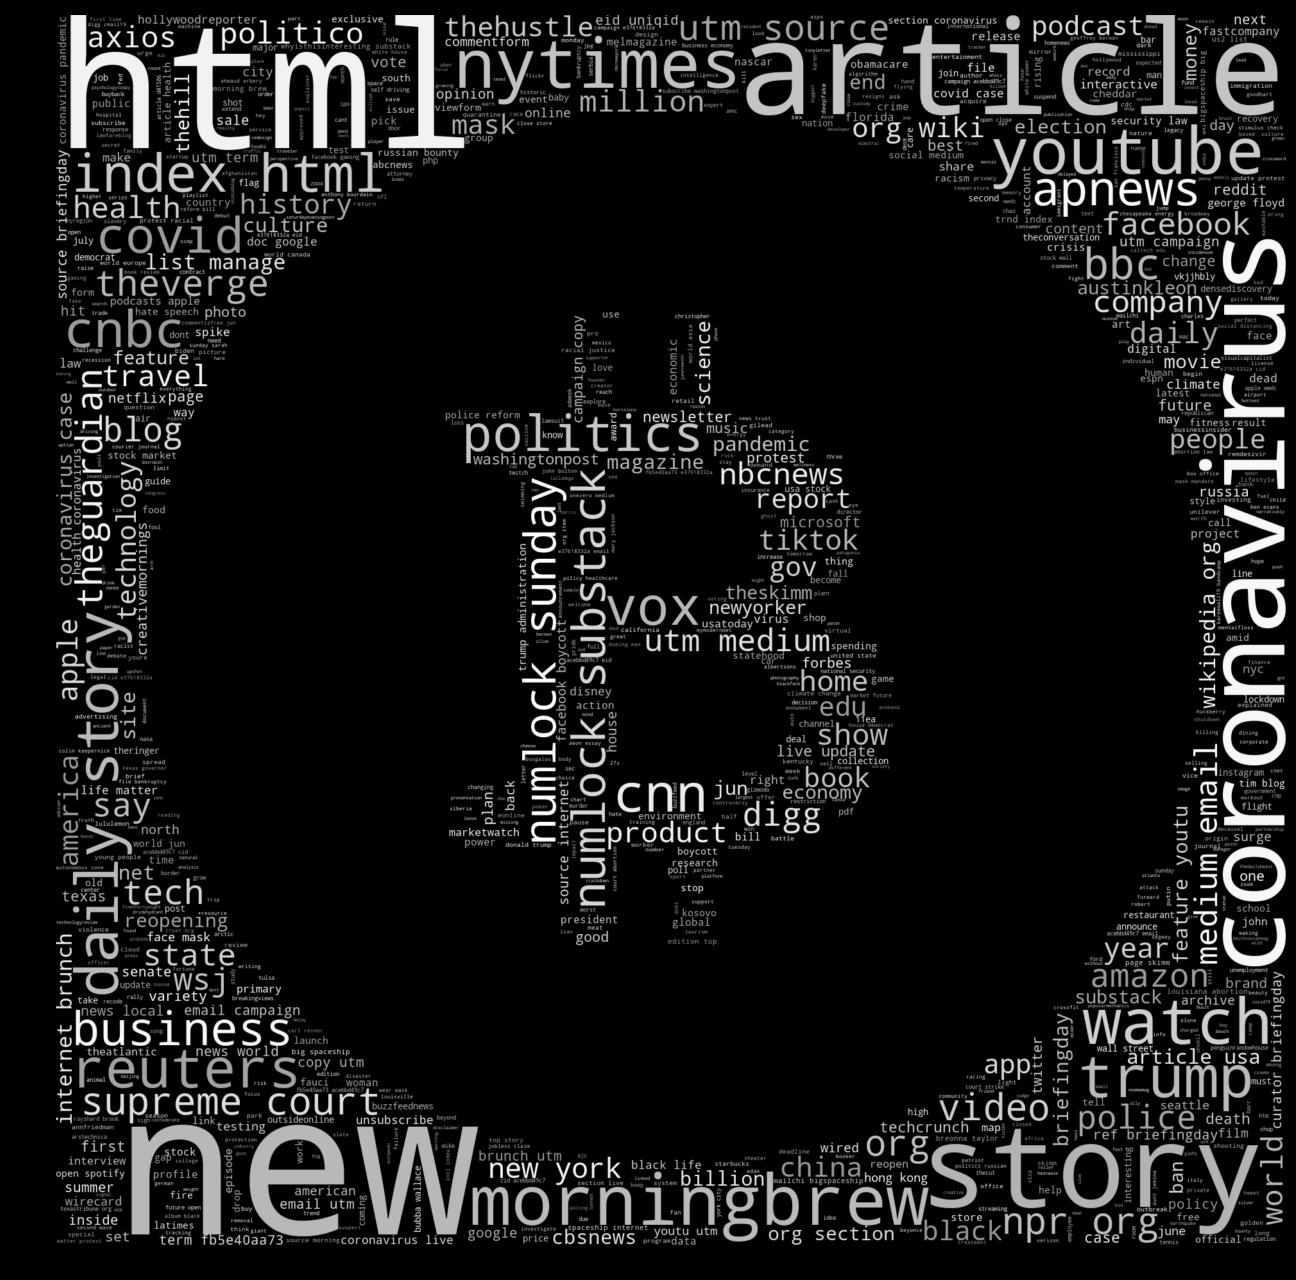

In [51]:
# Copy previous step data
df_S7 = df_S6.copy()
main_text_col_S7 = main_text_col_S6 if dataset_type == "NLP" else None

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    print("-------------------------------")
    print("STEP 7) TEXT LEMMATIZATION")
    print("-------------------------------\n")
    # Remove missing values from target variable
    missing_y = df_S7[y_var].isnull().sum()
    if missing_y > 0:
        log(f"Target variable '{y_var}' contains {missing_y} missing values → rows will be dropped", type="WARNING")
        df_S7 = df_S7.dropna(subset=[y_var])
    else:
        log(f"Target variable '{y_var}' has no missing values", type="SUCCESS")
    # Apply lemmatization to each list of tokens
    df_S7[main_text_col_S7] = df_S7[main_text_col_S7].apply(
        lambda token_list: lemmatize_tokens(
            token_list,
            apply_stopword_removal=apply_stopword_removal,
            stopword_language=stopword_language,
            case_sensitive_stopwords=case_sensitive_stopwords,
            apply_pos_tagging=apply_pos_tagging,
            exclude_digits=exclude_digits,
            min_word_length=min_word_length))
    log("Lemmatization completed successfully:", type="SUCCESS")
    log(f"Processed column: '{main_text_col_S7}'", type="INFO")
    display(df_S7.head(10))
    # Plot wordcloud
    # Build full text corpus
    all_words = []
    for row in df_S7[main_text_col_S7]:
        for tok in row:
            all_words.append(tok)
    text_for_wc = " ".join(all_words)
    # Load mask
    wordcloud_mask = np.array(Image.open(mask_path))
    # Generate WordCloud
    wordcloud = WordCloud(
        width = figWidth_unit*500,
        height = figHeight_unit*500,
        mask = wordcloud_mask,
        colormap = "viridis",
        background_color = "black",
        mode = "RGBA",
        max_words = 1000,
        random_state = random_seed
    ).generate(text_for_wc)
    # Plot with grayscale recoloring
    fig = plt.figure(figsize=(figWidth_unit*2, figHeight_unit*2), facecolor="black")
    # Inline grayscale color function
    grey_lambda = lambda *args, **kwargs: "hsl(0, 0%%, %d%%)" % random.randint(60, 100)
    plt.imshow(wordcloud.recolor(color_func=grey_lambda, random_state=random_seed), interpolation="bilinear")
    plt.show()
# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 7 - MISSING VALUES")
    print("-------------------------------\n")
    # Remove missing values from target variable
    missing_y = df_S7[y_var].isnull().sum()
    if missing_y > 0:
        log(f"Target variable '{y_var}' contains {missing_y} missing values → rows will be dropped", type="WARNING")
        df_S7 = df_S7.dropna(subset=[y_var])
    else:
        log(f"Target variable '{y_var}' has no missing values", type="SUCCESS")
    # Replace zeros by NaN for selected columns
    for col in zero_to_nan:
        if col in df_S7.columns:
            df_S7[col] = df_S7[col].replace(0, np.nan)
            log(f"Values equal to 0 in '{col}' have been replaced by NaN", type="WARNING")
    # Identify categorical variables usable as grouping keys for numeric imputation
    group_vars = []
    # Normal categorical attributes
    for col in category_att:
        if df_S7[col].nunique() <= grouping_max_unique:
            group_vars.append(col)
    # Add target as grouping variable if it is CATEGORICAL and has few unique values
    if y_var_type == "CATEGORIC":
        if df_S7[y_var].nunique() <= grouping_max_unique:
            group_vars.append(y_var)
            log(f"Target variable '{y_var}' added to grouping keys for numeric imputation", type="INFO")
    # Calculate missing percentages per column
    missing_pct = (df_S7.isnull().sum() / len(df_S7)) * 100
    missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)
    if len(missing_pct) == 0:
        log("DataFrame has no missing values at all (excluding target variable already handled)", type="SUCCESS")
    else:
        # Process each column with missing values
        for col in missing_pct.index:
            pct = missing_pct[col]
            log(f"Column: {col} → {pct:.2f}% missing", type="WARNING")
            # CASE 1: NUMERIC ATTRIBUTE
            if col in numeric_att:
                # CASE 1A: grouped median
                if pct > filling_threshold and len(group_vars) > 0:
                    medians = df_S7.groupby(group_vars)[col].median().reset_index()
                    medians = medians.rename(columns={col: f"median_{col}"})
                    df_S7 = pd.merge(df_S7, medians, on=group_vars, how="left")
                    df_S7[col] = df_S7[col].fillna(df_S7[f"median_{col}"])
                    df_S7 = df_S7.drop(columns=[f"median_{col}"])
                    log(f"FILLED missing numeric values in {col} using grouped median by {group_vars}", level=2, type="WARNING")
                # CASE 1B: global median
                elif pct > filling_threshold and len(group_vars) == 0:
                    df_S7[col] = df_S7[col].fillna(df_S7[col].median())
                    log(f"FILLED missing numeric values in {col} using global median (no grouping columns)", level=2, type="WARNING")
                # CASE 1C: drop rows
                elif pct <= filling_threshold:
                    df_S7 = df_S7.dropna(subset=[col])
                    log(f"DROPPED rows with missing values in {col} ({pct:.2f}% ≤ {filling_threshold}%)", level=2, type="WARNING")
            # CASE 2: CATEGORICAL ATTRIBUTE → mode imputation
            elif col in category_att:
                mode_value = df_S7[col].mode().iloc[0]
                df_S7[col] = df_S7[col].fillna(mode_value)
                log(f"FILLED missing categorical values in {col} using mode (most frequent value)", level=2, type="WARNING")
            # CASE 3: unsupported
            else:
                df_S7 = df_S7.dropna(subset=[col])
                log(f"DROPPED rows for missing values in {col} because it has unsupported type for imputation", level=2, type="INFO")
    # Print results
    log(f"Previous df's rows: {len(df_S6)}", type="INFO")
    log(f"Current df's rows: {len(df_S7)}", type="INFO")
    log(f"Current df's shape: {df_S7.shape}", type="INFO")
    log(f"Remaining missing values per column:\n{df_S7.isnull().sum()}", type="INFO")
    if make_missing_values_plots:
        # BEFORE vs AFTER missing values handling
        print("\n📊 VISUAL CHECK - BEFORE vs AFTER missing values handling")
        df_S7_before = df_S6.copy()   # Before missing-value handling
        df_S7_after = df_S7.copy()    # After missing-value handling
        if not numeric_att:
            log("This type of plot is non applicable because there are not NUMERIC variables in the DataFrame", type="WARNING")
        else:
            # Set plotting variables
            var_to_plot = numeric_att.copy()
            if y_var_type == "NUMERIC" and y_var not in var_to_plot:
                var_to_plot.insert(0, y_var)
            # Figure
            num_cols = 2
            num_rows = len(var_to_plot)
            fig, axes = plt.subplots(nrows = num_rows * 2, ncols = num_cols, figsize = (figWidth_unit * num_cols, figHeight_unit * num_rows), gridspec_kw={'height_ratios': [4, 0.5] * num_rows})
            for i, colname in enumerate(var_to_plot):
                # Row indices for histogram and boxplot of this variable
                hist_row  = i * 2
                box_row   = i * 2 + 1
                # Common bins (syncronize BEFORE and AFTER)
                xmin = min(df_S7_before[colname].min(), df_S7_after[colname].min())
                xmax = max(df_S7_before[colname].max(), df_S7_after[colname].max())
                common_bins = np.linspace(xmin, xmax, num_bins + 1)
                # ================
                # BEFORE PLOTS
                # ================
                before_hist_ax = axes[hist_row, 0]
                before_box_ax  = axes[box_row, 0]
                sns.histplot(ax = before_hist_ax, data = df_S7_before, x = colname, bins = num_bins, color = "gray", alpha = 0.35)
                before_hist_ax.set_title(colname + " - BEFORE")
                before_hist_ax.set_xlabel("")
                sns.boxplot(ax = before_box_ax, data = df_S7_before, x = colname, color = "lightgray")
                before_box_ax.set_xlabel("")
                # Store BEFORE axis limits
                xlim_hist_before = before_hist_ax.get_xlim()
                ylim_hist_before = before_hist_ax.get_ylim()
                xlim_box_before  = before_box_ax.get_xlim()
                # ================
                # AFTER PLOTS
                # ================
                after_hist_ax = axes[hist_row, 1]
                after_box_ax  = axes[box_row, 1]
                sns.histplot( ax = after_hist_ax, data = df_S7_after, x = colname, bins = common_bins)
                after_hist_ax.set_title(colname + " - AFTER")
                after_hist_ax.set_xlabel("")
                sns.boxplot(ax = after_box_ax, data = df_S7_after, x = colname)
                after_box_ax.set_xlabel("")
                # Syncronize axes limits
                after_hist_ax.set_xlim(xlim_hist_before)
                after_hist_ax.set_ylim(ylim_hist_before)
                after_box_ax.set_xlim(xlim_box_before)
            plt.tight_layout()
            plt.show()

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
elif dataset_type == "TIME-SERIES":
    print("-------------------------------")
    print("STEP 7 - MISSING VALUES")
    print("-------------------------------\n")
    # Remove missing values from target variable
    missing_y = df_S7[y_var].isnull().sum()
    if missing_y > 0:
        log(f"Target variable '{y_var}' contains {missing_y} missing values → rows will be dropped", type="WARNING")
        df_S7 = df_S7.dropna(subset=[y_var])
    else:
        log(f"Target variable '{y_var}' has no missing values", type="SUCCESS")
    # Print results
    log(f"Previous df's rows: {len(df_S6)}", type="INFO")
    log(f"Current df's rows: {len(df_S7)}", type="INFO")
    log(f"Current df's shape: {df_S7.shape}", type="INFO")
    log(f"Remaining missing values per column:\n{df_S7.isnull().sum()}", type="INFO")

## STEP 8 - non applicable

In [52]:
# -------------------------------
# INPUTS NEEDED IF dataset_type = "TABULAR"
# -------------------------------
low_outliers_threshold = 1.0        # [%] Max percentage of lower outliers allowed to remove
up_outliers_threshold = 1.0         # [% ]Max percentage of upper outliers allowed to remove
removal_type = "EXTREME OUTLIERS"   # Removal logic type (NORMAL or EXTREME outliers)
make_outliers_plots = True          # Make plots?

In [53]:
# Copy previous step data
df_S8 = df_S7.copy()

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
if dataset_type == "TIME-SERIES":
    log("This step is non-applicable for TIME-SERIES datasets", type="WARNING")

# -------------------------------
# NLP DATASET
# -------------------------------
elif dataset_type == "NLP":
    log("This step is non-applicable for NLP datasets", type="WARNING")

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 8 - CLEAN OUTLIERS")
    print("-------------------------------\n")
    # Print info
    display(df_S8.describe())
    # Outliers detection is applied over numeric attributes
    cols = []
    for col in numeric_att:
        if col in df_S8.columns.to_list():
            cols.append(col)
    # Initialize containers
    lower_limits = []
    upper_limits = []
    n_outliers_lower = []
    n_outliers_upper = []
    pct_outliers_lower = []
    pct_outliers_upper = []
    extreme_lower_limits = []
    extreme_upper_limits = []
    n_extreme_outliers_lower = []
    n_extreme_outliers_upper = []
    pct_extreme_outliers_lower = []
    pct_extreme_outliers_upper = []
    for col in cols:
        Q1 = df_S8[col].quantile(0.25)
        Q3 = df_S8[col].quantile(0.75)
        IQR = Q3 - Q1
        # Calulate limits
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        extreme_lower = Q1 - 3 * IQR
        extreme_upper = Q3 + 3 * IQR
        # Count num of outliers
        n_low = (df_S8[col] < lower).sum()
        n_high = (df_S8[col] > upper).sum()
        n_extreme_low = (df_S8[col] < extreme_lower).sum()
        n_extreme_high = (df_S8[col] > extreme_upper).sum()
        # Percentages of outliers
        pct_low = (n_low / len(df_S8.index)) * 100
        pct_high = (n_high / len(df_S8.index)) * 100
        pct_extreme_low = (n_extreme_low / len(df_S8.index)) * 100
        pct_extreme_high = (n_extreme_high / len(df_S8.index)) * 100
        # Save limits
        lower_limits.append(lower)
        upper_limits.append(upper)
        extreme_lower_limits.append(extreme_lower)
        extreme_upper_limits.append(extreme_upper)
        # Save num of outliers
        n_outliers_lower.append(n_low)
        n_outliers_upper.append(n_high)
        n_extreme_outliers_lower.append(n_extreme_low)
        n_extreme_outliers_upper.append(n_extreme_high)
        # Save percentages of outliers
        pct_outliers_lower.append(pct_low)
        pct_outliers_upper.append(pct_high)
        pct_extreme_outliers_lower.append(pct_extreme_low)
        pct_extreme_outliers_upper.append(pct_extreme_high)
    # Build DataFrame with all results
    df_limits = pd.DataFrame([
        lower_limits, upper_limits, n_outliers_lower, n_outliers_upper, pct_outliers_lower, pct_outliers_upper],
        columns=cols,
        index=["lower_limit", "upper_limit", "n_outliers_lower", "n_outliers_upper", "pct_outliers_lower", "pct_outliers_upper"])
    df_extreme_limits = pd.DataFrame([
        extreme_lower_limits, extreme_upper_limits, n_extreme_outliers_lower, n_extreme_outliers_upper, pct_extreme_outliers_lower, pct_extreme_outliers_upper],
        columns=cols,
        index=["extreme_lower_limit", "extreme_upper_limit", "n_extreme_outliers_lower", "n_extreme_outliers_upper", "pct_extreme_outliers_lower", "pct_extreme_outliers_upper"])
    # Display results
    display(df_limits)
    display(df_extreme_limits)
    # Outliers detection is applied over numeric attributes
    cols = []
    for col in numeric_att:
        if col in df_S8.columns.to_list():
            cols.append(col)
    if removal_type == "NORMAL OUTLIERS":
        # Loop through each column and apply filtering rules
        for col in cols:
            low_limit = df_limits.loc["lower_limit", col]
            high_limit = df_limits.loc["upper_limit", col]
            pct_low = df_limits.loc["pct_outliers_lower", col]
            pct_high = df_limits.loc["pct_outliers_upper", col]
            # Remove low outliers if below threshold
            print("\n")
            log(f"Attribute '{col}':", type="INFO")
            if pct_low == 0:
                log("None lower outliers detected", level=2, type="INFO")
            elif pct_low <= low_outliers_threshold:
                df_S8 = df_S8[df_S8[col] >= low_limit]
                log(f"REMOVED lower outliers ({pct_low:.2f}% <= {low_outliers_threshold}%)", level=2, type="WARNING")
            else:
                log(f"KEPT lower outliers ({pct_low:.2f}% > {low_outliers_threshold}%)", level=2, type="SUCCESS")
            # Remove high outliers if below threshold
            if pct_high == 0:
                log("None upper outliers detected", level=2, type="INFO")
            elif pct_high <= up_outliers_threshold:
                df_S8 = df_S8[df_S8[col] <= high_limit]
                log(f"REMOVED upper outliers ({pct_high:.2f}% <= {up_outliers_threshold}%)", level=2, type="WARNING")
            else:
                log(f"KEPT upper outliers ({pct_high:.2f}% > {up_outliers_threshold}%)", level=2, type="SUCCESS")
    elif removal_type == "EXTREME OUTLIERS":
        # Loop through each column and apply filtering rules
        for col in cols:
            low_limit = df_extreme_limits.loc["extreme_lower_limit", col]
            high_limit = df_extreme_limits.loc["extreme_upper_limit", col]
            pct_low = df_extreme_limits.loc["pct_extreme_outliers_lower", col]
            pct_high = df_extreme_limits.loc["pct_extreme_outliers_upper", col]
            # Remove low outliers if below threshold
            print("\n")
            log(f"Attribute '{col}':", type="INFO")
            if pct_low == 0:
                log("None extreme lower outliers detected", level=2, type="INFO")
            elif pct_low <= low_outliers_threshold:
                df_S8 = df_S8[df_S8[col] >= low_limit]
                log(f"REMOVED extreme lower outliers ({pct_low:.2f}% <= {low_outliers_threshold}%)", level=2, type="WARNING")
            else:
                log(f"KEPT extreme lower outliers ({pct_low:.2f}% > {low_outliers_threshold}%)", level=2, type="SUCCESS")
            # Remove high outliers if below threshold
            if pct_high == 0:
                log("None extreme upper outliers detected", level=2, type="INFO")
            elif pct_high <= up_outliers_threshold:
                df_S8 = df_S8[df_S8[col] <= high_limit]
                log(f"REMOVED extreme upper outliers ({pct_high:.2f}% <= {up_outliers_threshold}%)", level=2, type="WARNING")
            else:
                log(f"KEPT extreme upper outliers ({pct_high:.2f}% > {up_outliers_threshold}%)", level=2, type="SUCCESS")
    # Print results
    log("Outliers have been handled successfully:", type="SUCCESS")
    log(f"Previous df's rows: {len(df_S7)}", level=2, type="INFO")
    log(f"Current df's rows: {len(df_S8)}", level=2, type="INFO")
    log(f"Current DataFrame shape: {df_S8.shape}", level=2, type="INFO")
    display(df_S8.describe())
    if make_outliers_plots:
        # BEFORE vs AFTER Outliers handling
        print("\n📊 VISUAL CHECK - BEFORE vs AFTER outliers handling")
        df_S8_before = df_S7.copy()   # Before missing-value handling
        df_S8_after = df_S8.copy()    # After missing-value handling
        if not numeric_att:
            log("This type of plot is non applicable because there are not NUMERIC variables in the DataFrame", type="WARNING")
        else:
            # Set plotting variables
            var_to_plot = numeric_att
            # Figure
            num_cols = 2
            num_rows = len(var_to_plot)
            fig, axes = plt.subplots(nrows = num_rows * 2, ncols = num_cols, figsize = (figWidth_unit * num_cols, figHeight_unit * num_rows), gridspec_kw={'height_ratios': [4, 0.5] * num_rows})
            for i, colname in enumerate(var_to_plot):
                # Row indices for histogram and boxplot of this variable
                hist_row  = i * 2
                box_row   = i * 2 + 1
                # Set common bins (syncronize BEFORE and AFTER)
                xmin = min(df_S8_before[colname].min(), df_S8_after[colname].min())
                xmax = max(df_S8_before[colname].max(), df_S8_after[colname].max())
                common_bins = np.linspace(xmin, xmax, num_bins + 1)
                # Set colored area limits
                normal_low = df_limits.loc["lower_limit", colname]
                normal_up  = df_limits.loc["upper_limit", colname]
                extreme_low = df_extreme_limits.loc["extreme_lower_limit", colname]
                extreme_up  = df_extreme_limits.loc["extreme_upper_limit", colname]
                # ================
                # BEFORE PLOTS
                # ================
                before_hist_ax = axes[hist_row, 0]
                before_box_ax  = axes[box_row, 0]
                sns.histplot(ax = before_hist_ax, data = df_S8_before, x = colname, bins = num_bins, color = "gray", alpha = 0.35)
                before_hist_ax.set_title(colname + " - BEFORE")
                before_hist_ax.set_xlabel("")
                sns.boxplot(ax = before_box_ax, data = df_S8_before, x = colname, color = "lightgray")
                before_box_ax.set_xlabel("")
                # Outlier count
                pct_low_normal  = df_limits.loc["pct_outliers_lower", colname]
                pct_high_normal = df_limits.loc["pct_outliers_upper", colname]
                pct_low_extreme  = df_extreme_limits.loc["pct_extreme_outliers_lower", colname]
                pct_high_extreme = df_extreme_limits.loc["pct_extreme_outliers_upper", colname]
                # NORMAL Outliers
                if pct_low_normal > 0:
                    before_hist_ax.axvspan(normal_low, extreme_low, color="orange", alpha=0.22)
                    before_box_ax.axvspan(normal_low, extreme_low, color="orange", alpha=0.22)
                if pct_high_normal > 0:
                    before_hist_ax.axvspan(extreme_up, normal_up, color="orange", alpha=0.22)
                    before_box_ax.axvspan(extreme_up, normal_up, color="orange", alpha=0.22)
                # EXTREME Outliers
                if pct_low_extreme > 0:
                    before_hist_ax.axvspan(xmin, extreme_low, color="red", alpha=0.22)
                    before_box_ax.axvspan(xmin, extreme_low, color="red", alpha=0.22)
                if pct_high_extreme > 0:
                    before_hist_ax.axvspan(extreme_up, xmax, color="red", alpha=0.22)
                    before_box_ax.axvspan(extreme_up, xmax, color="red", alpha=0.22)
                # Store BEFORE limits
                xlim_hist_before = before_hist_ax.get_xlim()
                ylim_hist_before = before_hist_ax.get_ylim()
                xlim_box_before  = before_box_ax.get_xlim()
                # ================
                # AFTER PLOTS
                # ================
                after_hist_ax = axes[hist_row, 1]
                after_box_ax  = axes[box_row, 1]
                sns.histplot(ax = after_hist_ax, data = df_S8_after, x = colname, bins = common_bins)
                after_hist_ax.set_title(colname + " - AFTER")
                after_hist_ax.set_xlabel("")
                sns.boxplot(ax = after_box_ax, data = df_S8_after, x = colname)
                after_box_ax.set_xlabel("")
                # Check if outliers are still present in AFTER
                normal_low_present  = (df_S8_after[colname] < normal_low).any()
                normal_up_present   = (df_S8_after[colname] > normal_up).any()
                extreme_low_present = (df_S8_after[colname] < extreme_low).any()
                extreme_up_present  = (df_S8_after[colname] > extreme_up).any()
                # NORMAL Outliers
                if normal_low_present:
                    after_hist_ax.axvspan(normal_low, extreme_low, color="orange", alpha=0.22)
                    after_box_ax.axvspan(normal_low, extreme_low, color="orange", alpha=0.22)
                if normal_up_present:
                    after_hist_ax.axvspan(extreme_up, normal_up, color="orange", alpha=0.22)
                    after_box_ax.axvspan(extreme_up, normal_up, color="orange", alpha=0.22)
                # EXTREME Outliers
                if extreme_low_present:
                    after_hist_ax.axvspan(xmin, extreme_low, color="red", alpha=0.22)
                    after_box_ax.axvspan(xmin, extreme_low, color="red", alpha=0.22)
                if extreme_up_present:
                    after_hist_ax.axvspan(extreme_up, xmax, color="red", alpha=0.22)
                    after_box_ax.axvspan(extreme_up, xmax, color="red", alpha=0.22)
                # Legends
                before_hist_ax.legend(
                    handles=[
                        plt.Rectangle((0,0),1,1, facecolor='orange', alpha=0.45, label="NORMAL OUTLIERS"),
                        plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.45, label="EXTREME OUTLIERS")],
                    loc="upper right")
                after_hist_ax.legend(
                    handles=[
                        plt.Rectangle((0,0),1,1, facecolor='orange', alpha=0.45, label="NORMAL OUTLIERS"),
                        plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.45, label="EXTREME OUTLIERS")],
                    loc="upper right")
                # Syncronize axes limits
                after_hist_ax.set_xlim(xlim_hist_before)
                after_hist_ax.set_ylim(ylim_hist_before)
                after_box_ax.set_xlim(xlim_box_before)
            plt.tight_layout()
            plt.show()

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
elif dataset_type == "TIME-SERIES":
    log("This step is non-applicable for TIME-SERIES datasets", type="WARNING")

• ⚠️ This step is non-applicable for NLP datasets


## STEP 9 - non applicable

In [54]:
# -------------------------------
# INPUTS NEEDED IF dataset_type = "TABULAR"
# -------------------------------
corr_threshold = 0.9 # Correlation level considered as "too high"

In [55]:
# Copy previous step data
df_S9 = df_S8.copy()

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
if dataset_type == "TIME-SERIES":
    log("This step is non-applicable for TIME-SERIES datasets", type="WARNING")

# -------------------------------
# NLP DATASET
# -------------------------------
elif dataset_type == "NLP":
    log("This step is non-applicable for NLP datasets", type="WARNING")

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 9 - REMOVE NOISY ATTRIBUTES")
    print("-------------------------------\n")
    #  NUMERIC ATTRIBUTES (Pearson correlation)
    corr_matrix = df_S9[numeric_att].corr().abs()
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > corr_threshold:
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]
                if col_i not in to_drop:
                    to_drop.add(col_i)
    if to_drop:
        df_S9 = df_S9.drop(columns=list(to_drop), axis=1)
        log("High NUMERIC attributes correlation detected (Pearson Corr. > {corr_threshold}). Dropped:", type="WARNING")
        for col in to_drop:
            log(f"Attribute '{col}'", level=2, type="INFO")
    else:
        log("No NUMERIC attributes exceeded {corr_threshold} Pearson Correlation", type="SUCCESS")
    #  CATEGORICAL ATTRIBUTES (Cramér's V)
    to_drop_cat = set()
    if len(category_att) > 1:
        for i in range(len(category_att)):
            for j in range(i):
                v = cramers_v(df_S9[category_att[i]], df_S9[category_att[j]])
                if v > corr_threshold:
                    col_i = category_att[i]
                    col_j = category_att[j]
                    if col_i not in to_drop_cat:
                        to_drop_cat.add(col_i)
    if to_drop_cat:
        df_S9 = df_S9.drop(columns=list(to_drop_cat), axis=1)
        log(f"High CATEGORICAL attributes correlation association detected (Cramer’s V > {corr_threshold}). Dropped:", type="WARNING")
        for col in to_drop_cat:
            log(f"Attribute '{col}'", level=2, type="INFO")
    else:
        log("No CATEGORICAL attributes exceeded {corr_threshold} Cramer’s V", type="SUCCESS")
    # Update numeric_att
    updated_numeric = []
    for col in numeric_att:
        if col in df_S9.columns:
            updated_numeric.append(col)
    numeric_att = updated_numeric
    # Update category_att
    updated_category = []
    for col in category_att:
        if col in df_S9.columns:
            updated_category.append(col)
    category_att = updated_category
    # Update binary_att
    updated_binary = []
    for col in binary_att:
        if col in df_S9.columns:
            updated_binary.append(col)
    binary_att = updated_binary
    # Update multiclass_att
    updated_multiclass = []
    for col in multiclass_att:
        if col in df_S9.columns:
            updated_multiclass.append(col)
    multiclass_att = updated_multiclass
    # Print results
    log("Noisy attributes have been handled successfully:", type="SUCCESS")
    log(f"Previous df's columns: {len(df_S8.columns)}", level=2, type="INFO")
    log(f"Current df's columns: {len(df_S9.columns)}", level=2, type="INFO")
    log(f"Current DataFrame shape: {df_S9.shape}", level=2, type="INFO")
    display(df_S9.head())

• ⚠️ This step is non-applicable for NLP datasets


## STEP 10 - SPLIT

In [56]:
test_size = 0.2

In [57]:
# Copy previous step data
df_10 = df_S9.copy()

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
if dataset_type == "TIME-SERIES":
    log("This step is non-applicable for TIME-SERIES datasets", type="WARNING")

# -------------------------------
# NLP DATASET
# -------------------------------
elif dataset_type == "NLP":
    print("-------------------------------")
    print("STEP 10 - SPLIT")
    print("-------------------------------\n")
    # Separate attributes from target variable
    X = df_10.drop(labels = y_var, axis = 1)
    y = df_10[y_var]
    # Make split between Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_seed)
    # Print results
    log("Shape of DataFrames after SPLIT:", type="INFO")
    log(f"X_train: {X_train.shape}", level=2, custom_icon="🏋️")
    log(f"X_test: {X_test.shape}", level=2, custom_icon="🧪")
    log(f"y_train: {y_train.shape}", level=2, custom_icon="🏋️")
    log(f"y_test: {y_test.shape}", level=2, custom_icon="🧪")
    print("\n")
    log("Content of DataFrames after SPLIT:", type="INFO")
    log(f"X_train: {X_train.head(5)}", level=2, custom_icon="🏋️")
    log(f"X_test: {X_test.head(5)}", level=2, custom_icon="🧪")
    log(f"y_train: {y_train.head(5)}", level=2, custom_icon="🏋️")
    log(f"y_test: {y_test.head(5)}", level=2, custom_icon="🧪")
    print("\n")
    log("Info of DataFrames after SPLIT:", type="INFO")
    log(f"X_train: {X_train.info()}", level=2, custom_icon="🏋️")
    log(f"X_test: {X_test.info()}", level=2, custom_icon="🧪")
    log(f"y_train: {y_train.info()}", level=2, custom_icon="🏋️")
    log(f"y_test: {y_test.info()}", level=2, custom_icon="🧪")

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 10 - SPLIT")
    print("-------------------------------\n")
    # Separate attributes from target variable
    X = df_10.drop(labels = y_var, axis = 1)
    y = df_10[y_var]
    # Make split between Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_seed)
    # Print results
    log("Shape of DataFrames after SPLIT:", type="INFO")
    log(f"X_train: {X_train.shape}", level=2, custom_icon="🏋️")
    log(f"X_test: {X_test.shape}", level=2, custom_icon="🧪")
    log(f"y_train: {y_train.shape}", level=2, custom_icon="🏋️")
    log(f"y_test: {y_test.shape}", level=2, custom_icon="🧪")
    print("\n")
    log("Content of DataFrames after SPLIT:", type="INFO")
    log(f"X_train: {X_train.head(5)}", level=2, custom_icon="🏋️")
    log(f"X_test: {X_test.head(5)}", level=2, custom_icon="🧪")
    log(f"y_train: {y_train.head(5)}", level=2, custom_icon="🏋️")
    log(f"y_test: {y_test.head(5)}", level=2, custom_icon="🧪")
    print("\n")
    log("Info of DataFrames after SPLIT:", type="INFO")
    log(f"X_train: {X_train.info()}", level=2, custom_icon="🏋️")
    log(f"X_test: {X_test.info()}", level=2, custom_icon="🧪")
    log(f"y_train: {y_train.info()}", level=2, custom_icon="🏋️")
    log(f"y_test: {y_test.info()}", level=2, custom_icon="🧪")

-------------------------------
STEP 10 - SPLIT
-------------------------------

• ℹ️ Shape of DataFrames after SPLIT:
   - 🏋️ X_train: (1895, 1)
   - 🧪 X_test: (474, 1)
   - 🏋️ y_train: (1895,)
   - 🧪 y_test: (474,)


• ℹ️ Content of DataFrames after SPLIT:
   - 🏋️ X_train:                                                     url
173   [http, www, psychologytoday, com, blog, beauty...
1308  [http, www, wired, article, door, door, salesp...
911   [http, firstwefeast, com, eat, anthony, bourda...
478   [http, www, businessinsider, com, amazon, goog...
1924  [http, www, legacy, com, obituary, nytimes, ob...
   - 🧪 X_test:                                                     url
1299    [http, goldenhearts, oldest, golden, retriever]
204       [http, wikipedia, org, wiki, message, bottle]
2159  [http, subscribe, washingtonpost, com, newslet...
839   [http, www, nytimes, com, world, serb, renew, ...
807   [http, nymag, com, intelligencer, peter, stein...
   - 🏋️ y_train: 173     0
1308    0


## STEP 11 - SCALLING

In [58]:
# -------------------------------
# INPUTS NEEDED IF dataset_type = "TABULAR"
# -------------------------------
make_scalling = False
scaler_dic={# Instance scaler for each numeric attribute - change manually StandardScaler() or MinMaxScaler()
}

In [59]:
# Copy previous step data
X_train_es = X_train.copy()
X_test_es = X_test.copy()

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
if dataset_type == "TIME-SERIES":
    log("This step is non-applicable for TIME-SERIES datasets", type="WARNING")

# -------------------------------
# NLP DATASET
# -------------------------------
elif dataset_type == "NLP":
    log("This step is non-applicable for NLP datasets", type="WARNING")

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 11 - SCALLING")
    print("-------------------------------\n")
    for col in X_train.columns:
        if col in numeric_att:
            scaler_dic[col] = StandardScaler()
    if not numeric_att:
        X_train_es = X_train_es[numeric_att]
        X_test_es = X_test_es[numeric_att]
        log("SCALLING is non applicable for this case, because there are not NUMERIC attributes in the DataFrame", type="WARNING")
    elif not make_scalling:
        X_train_es = X_train_es[numeric_att]
        X_test_es = X_test_es[numeric_att]
        log("SCALLING is is not carried out, set make_scalling = True", type="WARNING")
        display(X_train_es.head())
    else:
        # Fit scalers ONLY on train data
        for col in numeric_att:
            scaler_dic[col].fit(X_train_es[[col]])
        log("All Scalers have been trained successfully", type="SUCCESS")
        # Apply scalers and create scaled columns
        scaled_cols = []
        for col in numeric_att:
            # Detect scaler type
            scaler_name = scaler_dic[col].__class__.__name__
            # Set suffix
            if scaler_name == "StandardScaler":
                suffix = "_SS"
            elif scaler_name == "MinMaxScaler":
                suffix = "_MM"
            else:
                suffix = "_Scaled"
            # Transform 
            X_train_es[col + suffix] = scaler_dic[col].transform(X_train_es[[col]])
            X_test_es[col + suffix]  = scaler_dic[col].transform(X_test_es[[col]])
            scaled_cols.append(col + suffix)
            log(f"Train/Test scaled for: {col} using {scaler_name} → new column: {col + suffix}", type="SUCCESS")
        # Keep only scaled columns
        X_train_es = X_train_es[scaled_cols]
        X_test_es  = X_test_es[scaled_cols]
        log("Final scaled datasets created successfully!", type="SUCCESS", bold=True)
        display(X_train_es.head())

• ⚠️ This step is non-applicable for NLP datasets


## STEP 12 - TEXT VECTORIZATION

In [60]:
# -------------------------------
# INPUTS NEEDED IF dataset_type = "NLP"
# -------------------------------
make_vectorization_plots = True        # Draw PCA comparison plots between COUNT and TF-IDF
max_features_manual = None             # Set a number manually, or None for auto selection
min_df_threshold = 1                   # Ignore tokens that appear in fewer than N documents
rare_word_cutoff = 3                   # Words appearing < rare_word_cutoff considered "rare"
long_text_threshold = 40               # If avg words per doc > threshold → increase vocab

# -------------------------------
# INPUTS NEEDED IF dataset_type = "TABULAR"
# -------------------------------
make_encoding = True

-------------------------------
STEP 12) TEXT VECTORIZATION
-------------------------------

• ℹ️ Total vocabulary size: 4775
• ℹ️ Average words per document: 9.5
• ℹ️ Rare-word ratio: 0.79
• ℹ️ Auto-selected max_features = 3000
• ✅ Vectorization completed successfully (COUNT + TF-IDF)

📊 PCA 2D VISUALIZATION


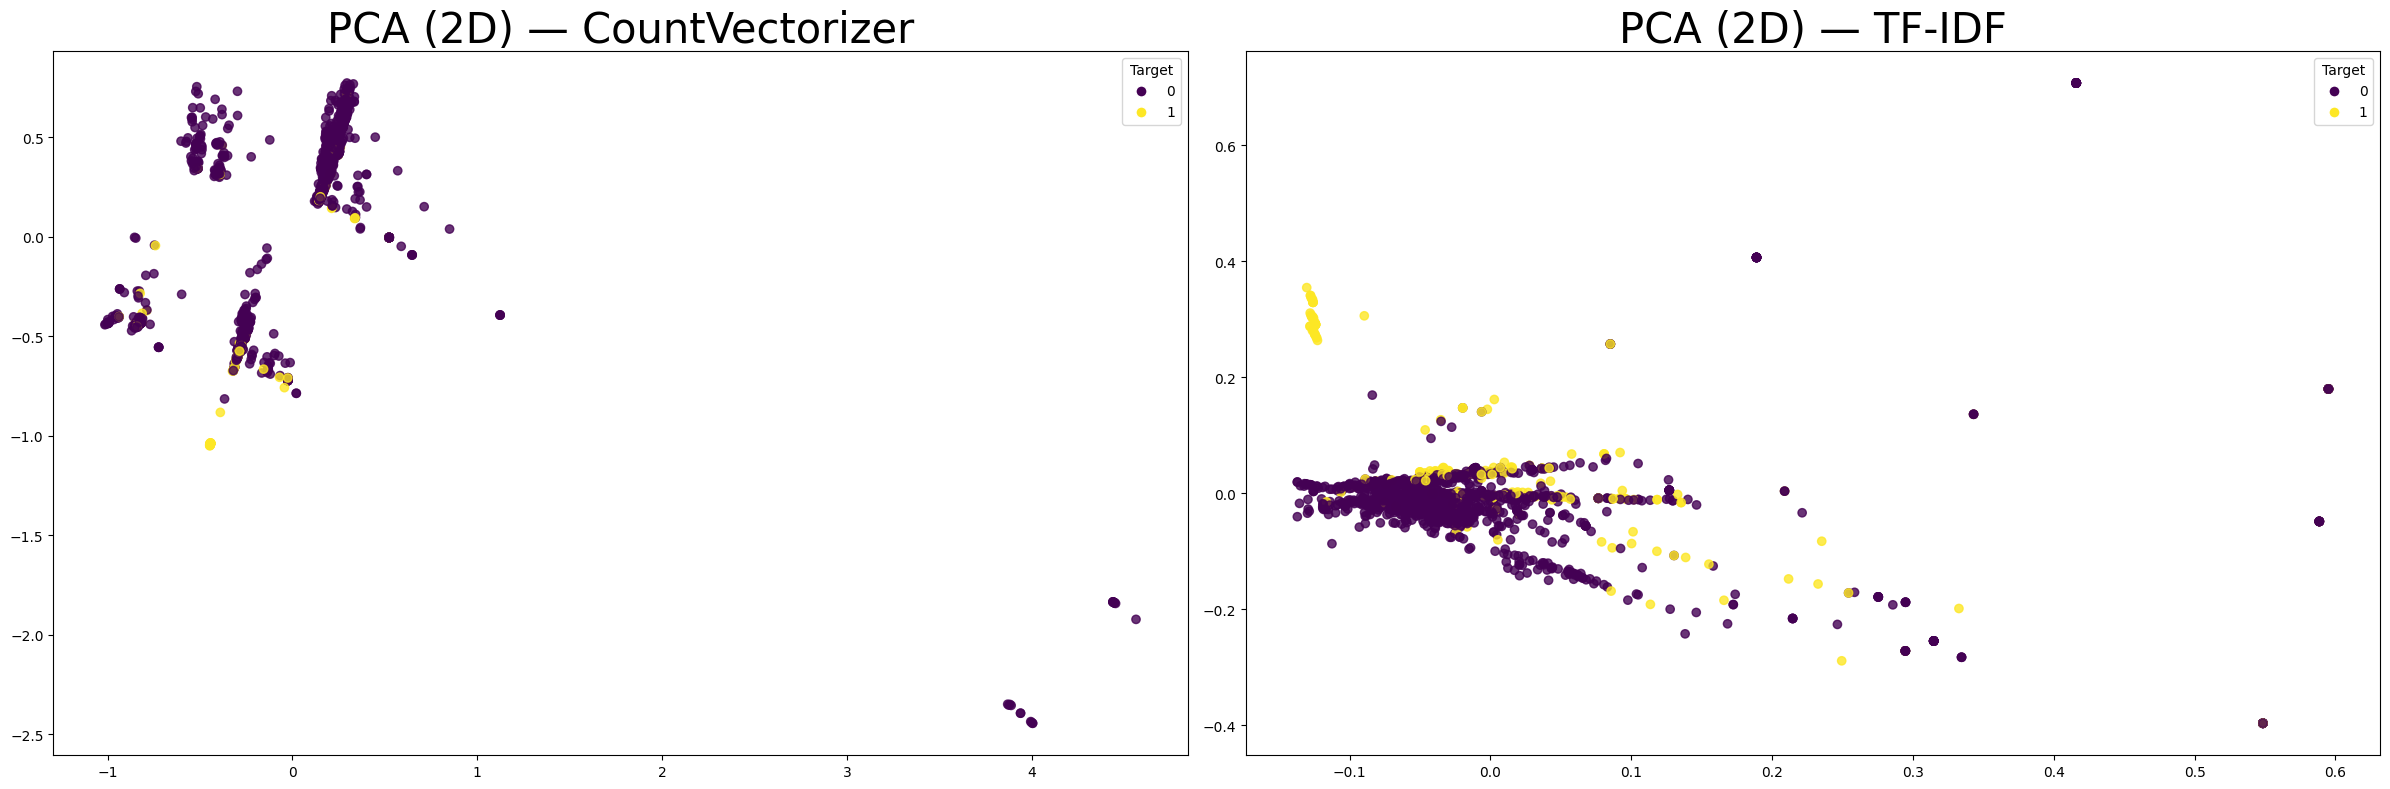



• ✅ Auto-selected vectorizer: TFIDF
• ✅ Auto-selected Vectorizer (TFIDF) instanced successfully
• ✅ Final vectorized datasets created successfully


,0559fa41cd68,05cbcd578ffef923e4480b4a8bb15c7e,06232898a34f,09785e274676e46351c70644d2b77215,0e9,10x,11e9,11ea,12news,13d2pf7utxfkgljz6z,...,zone,zoo,zoom,zooniverse,zoox,zuck,zuckerberg,zuihitsu,zwift,zyguxzjc
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# Copy previous step data
X_train_en = X_train.copy()
y_train_en = y_train.copy()
X_test_en = X_test.copy()
main_text_col_12 = main_text_col_S7 if dataset_type == "NLP" else None

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
if dataset_type == "TIME-SERIES":
    log("This step is non-applicable for TIME-SERIES datasets", type="WARNING")

# -------------------------------
# NLP DATASET
# -------------------------------
elif dataset_type == "NLP":
    print("-------------------------------")
    print("STEP 12) TEXT VECTORIZATION")
    print("-------------------------------\n")
    # Reconstruct text from tokens
    text_series = X_train_en[main_text_col_12].apply(lambda token_list: " ".join(token_list))
    # Number of documents
    num_texts = len(text_series)
    # Build vocabulary
    vocab = set()
    for doc_tokens in X_train_en[main_text_col_12]:
        for word in doc_tokens:
            vocab.add(word)
    vocab_size = len(vocab)
    # Compute avg words per document
    word_lengths = []
    for doc_tokens in X_train_en[main_text_col_12]:
        word_lengths.append(len(doc_tokens))
    avg_words_per_text = np.mean(word_lengths)
    # Count word frequencies
    word_counts = {}
    for doc_tokens in X_train_en[main_text_col_12]:
        for word in doc_tokens:
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
    # Identify rare words
    rare_words = []
    for word, count in word_counts.items():
        if count < rare_word_cutoff:
            rare_words.append(word)
    rare_ratio = len(rare_words) / vocab_size if vocab_size > 0 else 0.0
    log(f"Total vocabulary size: {vocab_size}", type="INFO")
    log(f"Average words per document: {avg_words_per_text:.1f}", type="INFO")
    log(f"Rare-word ratio: {rare_ratio:.2f}", type="INFO")
    # 3) Auto-determine max_features
    if max_features_manual is not None:
        max_features_auto = max_features_manual
        log(f"Using manual max_features = {max_features_manual}", type="INFO")
    else:
        # Base rule by dataset size
        if num_texts < 3000:
            max_features_auto = 2000
        elif num_texts <= 20000:
            max_features_auto = 5000
        else:
            max_features_auto = 7000
        # Ensure vocabulary is not smaller
        if vocab_size < max_features_auto:
            max_features_auto = vocab_size
        # If too many rare words, expand vocabulary allowance
        if rare_ratio > 0.50:
            max_features_auto = int(max_features_auto * 1.5)
        # If documents are long, increase vocabulary
        if avg_words_per_text > long_text_threshold:
            max_features_auto = int(max_features_auto * 1.5)
        log(f"Auto-selected max_features = {max_features_auto}", type="INFO")
    # Isntance vectorizers
    count_vec = CountVectorizer(max_features=max_features_auto, min_df=min_df_threshold)
    tfidf_vec = TfidfVectorizer(max_features=max_features_auto, min_df=min_df_threshold)
    # Fit vectorizers
    count_X = count_vec.fit_transform(text_series).toarray()
    tfidf_X = tfidf_vec.fit_transform(text_series).toarray()
    log("Vectorization completed successfully (COUNT + TF-IDF)", type="SUCCESS")
    # PCA 2D Visualization
    if make_vectorization_plots:
        print("\n📊 PCA 2D VISUALIZATION")
        pca = PCA(n_components=2)
        count_2D = pca.fit_transform(count_X)
        tfidf_2D = pca.fit_transform(tfidf_X)
        # Prepare plot
        fig, axes = plt.subplots(1, 2,figsize=(figWidth_unit * 2, figHeight_unit * 1))
        classes = sorted(y_train_en.unique())
        colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
        # COUNT plot
        axes[0].scatter(count_2D[:, 0], count_2D[:, 1], c=y_train_en, cmap="viridis", alpha=0.8)
        axes[0].set_title("PCA (2D) — CountVectorizer", fontsize=plot_title_font_size)
        # Legend
        handles_count = []
        for i, cls in enumerate(classes):
            handles_count.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=8, label=str(cls)))
        axes[0].legend(handles=handles_count, title="Target")
        # TF-IDF plot
        axes[1].scatter(tfidf_2D[:, 0], tfidf_2D[:, 1], c=y_train_en, cmap="viridis", alpha=0.8)
        axes[1].set_title("PCA (2D) — TF-IDF", fontsize=plot_title_font_size)
        handles_tfidf = []
        for i, cls in enumerate(classes):
            handles_tfidf.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=8, label=str(cls)))
        axes[1].legend(handles=handles_tfidf, title="Target")
        plt.tight_layout()
        plt.show()
    # Auto-select best Vectorizer
    best_vectorizer_name_S8 = "TFIDF"
    if y_var_subtype in ["BINARY", "MULTICLASS"]:
        try:
            score_count = silhouette_score(count_2D, y_train_en)
            score_tfidf = silhouette_score(tfidf_2D, y_train_en)
            if score_count > score_tfidf:
                best_vectorizer_name_S8 = "COUNT"
        except:
            pass
    print("\n")
    log(f"Auto-selected vectorizer: {best_vectorizer_name_S8}", type="SUCCESS", bold=True)
     # Instance selected vectorizer
    if best_vectorizer_name_S8 == "COUNT":
        vectorizer = CountVectorizer()
        vectorizer_name = "CountVectorizer()"
    else:
        vectorizer = TfidfVectorizer()
        vectorizer_name = "TfidfVectorizer()"
    log(f"Auto-selected Vectorizer ({best_vectorizer_name_S8}) instanced successfully", type="SUCCESS")
    # Train vectorizer wiht TRAIN data and transform TRAIN + TEST
    X_train_en = vectorizer.fit_transform(X_train_en[main_text_col_12].astype(str)).toarray()
    X_test_en = vectorizer.transform(X_test_en[main_text_col_12].astype(str)).toarray()
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    # Convert array to DataFrame
    X_train_en = pd.DataFrame(X_train_en, index=X_train.index, columns=feature_names)
    X_test_en = pd.DataFrame(X_test_en, index=X_test.index, columns=feature_names)
    log("Final vectorized datasets created successfully", type="SUCCESS")
    display(X_train_en.head())

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 12 - ENCODING")
    print("-------------------------------\n")
    if not category_att:
        X_train_en = X_train_en[category_att]
        X_test_en = X_test_en[category_att]
        log("ENCODING is non applicable for this case, because there are not CATEGORIC attributes in the DataFrame", type="WARNING")
    elif not make_encoding:
        X_train_en = X_train_en[category_att]
        X_test_en = X_test_en[category_att]
        log("ENCODING is is not carried out, set make_encoding = True", type="WARNING")
        display(X_train_en.head())
    else:
        # List of columns
        columns = X_train_en.columns.tolist()
        # Create encoder instance for each categorical attribute
        encoder_dic = {}
        for col in category_att:
            if col in binary_att:
                encoder_dic[col] = LabelEncoder()
                log(f"Encoder instanced successfully for {col}: LabelEncoder()", type="SUCCESS")
            elif col in multiclass_att:
                encoder_dic[col] = OneHotEncoder(sparse_output=False)
                log(f"Encoder instanced successfully for {col}: OneHotEncoder()", type="SUCCESS")
        # Train encoders with TRAIN data only
        for col in category_att:
            encoder = encoder_dic[col]
            if isinstance(encoder, LabelEncoder):
                encoder.fit(X_train_en[col])        # LabelEncoder needs 1D
                log(f"Encoder trained successfully with {col} from Train: LabelEncoder()", type="SUCCESS")
            elif isinstance(encoder, OneHotEncoder):
                encoder.fit(X_train_en[[col]])      # OHE needs 2D
                log(f"Encoder trained successfully with {col} from Train: OneHotEncoder()", type="SUCCESS")
        # Apply encoders to TRAIN + TEST
        for col in category_att:
            encoder = encoder_dic[col]
            if isinstance(encoder, LabelEncoder):
                X_train_en[col + "_LE"] = encoder.transform(X_train_en[col])
                X_test_en[col + "_LE"] = encoder.transform(X_test_en[col])
                log(f"Train/Test encoded for: {col} using LabelEncoder()", type="SUCCESS")
            elif isinstance(encoder, OneHotEncoder):
                # Transform train and test
                train_encoded = encoder.transform(X_train_en[[col]])
                test_encoded = encoder.transform(X_test_en[[col]])
                # New names
                ohe_colnames = encoder.get_feature_names_out([col])
                ohe_colnames = [name + "_OHE" for name in ohe_colnames]
                # Convert to DataFrames
                train_ohe_df = pd.DataFrame(train_encoded, index=X_train_en.index, columns=ohe_colnames)
                test_ohe_df = pd.DataFrame(test_encoded, index=X_test_en.index, columns=ohe_colnames)
                # Concatenate new cols
                X_train_en = pd.concat([X_train_en, train_ohe_df], axis=1)
                X_test_en = pd.concat([X_test_en, test_ohe_df], axis=1)
                log(f"Train/Test encoded for: {col} using OneHotEncoder()", type="SUCCESS")
        # Keep only encoded columns
        encoded_cols = []
        for col in category_att:
            encoder = encoder_dic[col]
            if isinstance(encoder, LabelEncoder):
                encoded_cols.append(col + "_LE")
            elif isinstance(encoder, OneHotEncoder):
                ohe_colnames = encoder.get_feature_names_out([col])
                for name in ohe_colnames:
                    encoded_cols.append(name + "_OHE")
        X_train_en = X_train_en[encoded_cols]
        X_test_en = X_test_en[encoded_cols]
        log("Final encoded datasets created successfully", type="SUCCESS")
        display(X_train_en.head())

## STEP 13 - ASSEMBLY

In [71]:
# Copy previous step data
X_train_S13 = X_train.copy()
X_test_S13 = X_test.copy()
X_train_es_S13 = X_train_es.copy()
X_test_es_S13 = X_test_es.copy()
X_train_en_S13 = X_train_en.copy()
X_test_en_S13 = X_test_en.copy()

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------        
if dataset_type == "TIME-SERIES":
    print("-------------------------------")
    print("STEP 13 - ASSEMBLY")
    print("-------------------------------\n")
    # Concatenate NUMERIC_var_scaled with CATEGORY_var_encoded
    X_train_assembled = X_train_S13
    X_test_assembled = X_test_S13
    # Print results
    log(f"X_train_assembled {X_train_assembled.shape}", custom_icon="🧮")
    display(X_train_assembled.head())
    print("\n")
    log(f"X_test_assembled {X_test_assembled.shape}", custom_icon="🧮")
    display(X_test_assembled.head())

# -------------------------------
# NLP DATASET
# -------------------------------
elif dataset_type == "NLP":
    print("-------------------------------")
    print("STEP 13 - ASSEMBLY")
    print("-------------------------------\n")
    # Concatenate NUMERIC_var_scaled with CATEGORY_var_encoded
    X_train_assembled = X_train_en_S13
    X_test_assembled = X_test_en_S13
    # Print results
    log(f"X_train_assembled {X_train_assembled.shape}", custom_icon="🧮")
    display(X_train_assembled.head())
    print("\n")
    log(f"X_test_assembled {X_test_assembled.shape}", custom_icon="🧮")
    display(X_test_assembled.head())

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    print("-------------------------------")
    print("STEP 13 - ASSEMBLY")
    print("-------------------------------\n")
    # Concatenate NUMERIC_var_scaled with CATEGORY_var_encoded
    X_train_assembled = pd.concat([X_train_es, X_train_en], axis=1)
    X_test_assembled = pd.concat([X_test_es, X_test_en], axis=1)
    # Print results
    log(f"X_train_assembled {X_train_assembled.shape}", custom_icon="🧮")
    display(X_train_assembled.head())
    print("\n")
    log(f"X_test_assembled {X_test_assembled.shape}", custom_icon="🧮")
    display(X_test_assembled.head())

-------------------------------
STEP 13 - ASSEMBLY
-------------------------------

• 🧮 X_train_assembled (1895, 4801)


,0559fa41cd68,05cbcd578ffef923e4480b4a8bb15c7e,06232898a34f,09785e274676e46351c70644d2b77215,0e9,10x,11e9,11ea,12news,13d2pf7utxfkgljz6z,...,zone,zoo,zoom,zooniverse,zoox,zuck,zuckerberg,zuihitsu,zwift,zyguxzjc
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




• 🧮 X_test_assembled (474, 4801)


,0559fa41cd68,05cbcd578ffef923e4480b4a8bb15c7e,06232898a34f,09785e274676e46351c70644d2b77215,0e9,10x,11e9,11ea,12news,13d2pf7utxfkgljz6z,...,zone,zoo,zoom,zooniverse,zoox,zuck,zuckerberg,zuihitsu,zwift,zyguxzjc
1299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## STEP 16 - PREDICTION MODELS

In [62]:
prediction_horizon = 360

In [63]:
print("STEP 16) PREDICTION MODELS")

# Copy previous time-series
df_timeseries_S7 = df_timeseries_S6.copy()
period_S7 = period_S6
seasonal_peaks_S7 = seasonal_peaks_S6

# ======================================================
#  ARIMA MODEL WITH SUGGESTED VALUES
# ======================================================
# Instance ARIMA model
arima_model = ARIMA(endog = df_timeseries_S7, order = (suggested_p, suggested_d, suggested_q))
# Train ARIMA model
arima_result = arima_model.fit()
# Predict with trained ARIMA model
prediction_ARIMA = arima_result.predict(start  = len(df_timeseries_S7), end= len(df_timeseries_S7) + prediction_horizon)

# ======================================================
#  AUTO ARIMA
# ======================================================
# Decide seasonal behaviour for auto_arima
auto_arima_m = get_auto_arima_m(period=period_S7,seasonal_peaks = seasonal_peaks_S6)
if auto_arima_m > 1:
    auto_arima_seasonal = True
else:
    auto_arima_seasonal = False
# Instance AUTO ARIMA model
auto_arima_model = auto_arima(y=df_timeseries_S7, seasonal = auto_arima_seasonal, trace = False, m = auto_arima_m)
# Retrieve orders
auto_p, auto_d, auto_q = auto_arima_model.order
# Predict with trained AUTO ARIMA model
prediction_AUTO_ARIMA = auto_arima_model.predict(prediction_horizon)

# ======================================================
#  COMPARISON
# ======================================================
log(f"ARIMA (manual): selected order (p,d,q)=({suggested_p},{suggested_d},{suggested_q})", level=1, type="INFO")
log(f"AUTO-ARIMA: selected order (p,d,q)=({auto_p},{auto_d},{auto_q}) with seasonal={auto_arima_seasonal}, m={auto_arima_m}", level=1, type="INFO")

if (suggested_p == auto_p) and (suggested_d == auto_d) and (suggested_q == auto_q):
    log(f"ARIMA vs AUTO-ARIMA: Orders MATCH", level=1, type="SUCCESS", bold=True)
else:
    log(f"ARIMA vs AUTO-ARIMA: Orders DO NOT MATCH", level=1, type="WARNING", bold=True)

# ======================================================
#  FORECAST PLOT — ARIMA
# ======================================================
fig_arima, ax_arima = plt.subplots(nrows=1, ncols=1, figsize=(2 * figWidth_unit, 1 * figHeight_unit))
# Plot original series
ax_arima.plot(df_timeseries_S7, label="Original Time-series")
# Plot ARIMA forecast
ax_arima.plot(prediction_ARIMA, label="Forecast (ARIMA)", color="red", linewidth=5, linestyle="dashed")
# Title, labels, ticks and legend
ax_arima.set_title(label=f"Forecast with ARIMA(p={suggested_p}, d={suggested_d}, q={suggested_q})", fontsize=plot_title_font_size)
ax_arima.set_xlabel(xlabel=df_timeseries_S7.index.name, fontsize=plot_label_font_size)
ax_arima.set_ylabel(ylabel=df_timeseries_S7.name, fontsize=plot_label_font_size)
ax_arima.tick_params(labelsize=plot_tick_font_size)
ax_arima.legend(fontsize=plot_text_font_size)
ax_arima.grid(True, linestyle="dotted", linewidth=0.5, color="black")
# Show plot
plt.tight_layout()
plt.show()

# ======================================================
#  FORECAST PLOT — AUTO ARIMA
# ======================================================
fig_auto, ax_auto_arima = plt.subplots(nrows=1, ncols=1, figsize=(2 * figWidth_unit, 1 * figHeight_unit))
# Plot original series
ax_auto_arima.plot(df_timeseries_S7, label="Original Time-series")
# Plot AUTO-ARIMA forecast
ax_auto_arima.plot(prediction_AUTO_ARIMA, label="Forecast (AUTO-ARIMA)", color="green", linewidth=5, linestyle="dashed")
# Title, labels, ticks and legend
ax_auto_arima.set_title(label=f"Forecast with AUTO-ARIMA(p={auto_p}, d={auto_d}, q={auto_q})", fontsize=plot_title_font_size)
ax_auto_arima.set_xlabel(xlabel=df_timeseries_S7.index.name, fontsize=plot_label_font_size)
ax_auto_arima.set_ylabel(ylabel=df_timeseries_S7.name, fontsize=plot_label_font_size)
ax_auto_arima.tick_params(labelsize=plot_tick_font_size)
ax_auto_arima.legend(fontsize=plot_text_font_size)
ax_auto_arima.grid(True, linestyle="dotted", linewidth=0.5, color="black")
# Show plot
plt.tight_layout()
plt.show()

STEP 16) PREDICTION MODELS


AttributeError: 'NoneType' object has no attribute 'copy'

## STEP 8 - SAVE MODELS

In [ ]:
models_output_path = "../models/"   # Folder where models will be saved
rev_to_use = 0

In [ ]:
print("STEP 8) SAVE MODELS")

arima_filename = models_output_path + f"ARIMA_rev{rev_to_use}.sav"
dump(arima_result, open(arima_filename, "wb"))
log(f"Model saved: {arima_filename}", level=1, type="SUCCESS")

auto_arima_filename = models_output_path + f"AUTO_MANUAL_rev{rev_to_use}.sav"
dump(auto_arima_model, open(auto_arima_filename, "wb"))
log(f"Model saved: {auto_arima_filename}", level=1, type="SUCCESS")